In [1]:
import numpy as np
import pandas as pd

import random
random.seed(28)
np.random.seed(28)

import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import os
import copy
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import time
from collections import Counter
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
#import eli5
import shap
from IPython.display import HTML
import json

import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
pd.set_option('max_rows', 500)
import re

import os

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', -1)

np.random.seed(2206)

# Read the data

In [2]:
train = pd.read_csv("../data/training_v2.csv")
samplesubmission = pd.read_csv("../data/samplesubmission.csv")
test = pd.read_csv("../data/unlabeled.csv")
dictionary = pd.read_csv("../data/WiDS Datathon 2020 Dictionary.csv")
solution_template = pd.read_csv("../data/solution_template.csv")

print('train ' , train.shape)
print('test ' , test.shape)
print('samplesubmission ' , samplesubmission.shape)
print('solution_template ' , solution_template.shape)
print('dictionary ' , dictionary.shape)

train  (91713, 186)
test  (39308, 186)
samplesubmission  (3, 2)
solution_template  (39308, 2)
dictionary  (188, 6)


In [3]:
dico = pd.DataFrame(dictionary.T.head(6))
dico.columns=list(dico.loc[dico.index == 'Variable Name'].unstack())
dico = dico.loc[dico.index != 'Variable Name']
dico.columns
train_stat = pd.DataFrame(train.describe())
train_stat2 = pd.concat([dico,train_stat],axis=0)
train_stat2.head(20)

age                                                                                                                   aids                                                                                              albumin_apache                      apache_2_bodysystem                             apache_2_diagnosis                      apache_3j_bodysystem                                                                        apache_3j_diagnosis                                                                                                                                    apache_4a_hospital_death_prob                                                                                                                                   apache_4a_icu_death_prob                                                   apache_post_operative  \
Category         demographic                               APACHE comorbidity                                                                                                     APACHE covariate                                                                                            APACHE grouping                          APACHE covariate                               APACHE grouping                           APACHE covariate                                                                           APACHE prediction                                                                                                                                                APACHE prediction                                                                                                                                          APACHE covariate                                                         
Unit of Measure  Years                                     None                                                                                                                   g/L                                                                                                         None                                     None                                           None                                      None                                                                                       None                                                                                                                                                             None                                                                                                                                                       None                                                                     
Data Type        numeric                                   binary                                                                                                                 numeric                                                                                                     string                                   string                                         string                                    string                                                                                     numeric                                                                                                                                                          numeric                                                                                                                                                    binary                                                                   
Description      The age of the patient on unit admission  Whether the patient has a definitive diagnosis of acquired immune deficiency syndrome (AIDS) (not HIV positive alone)  The albumin concentration measured during the first 24 hours which results in the highest APACHE III score  Admission diagnosis group for APACHE II  The APACHE II diagnosis for the ICU admission  Admission diagnosis group for APACHE III  The APACHE III-J sub-diagnosis code which best des

# OverView of the dataset

In [4]:
train_stat2.T.head(200)

Category         Unit of Measure Data Type                                                                                                                                                                                                                                                                                                              Description           Example                count                 mean                  std                  min                  25%                  50%                  75%                  max
age                            demographic                Years                   numeric   The age of the patient on unit admission                                                                                                                                                                                                                                                                                 None                        87,485.00                62.31                16.78                16.00                52.00                65.00                75.00                89.00
aids                           APACHE comorbidity         None                    binary    Whether the patient has a definitive diagnosis of acquired immune deficiency syndrome (AIDS) (not HIV positive alone)                                                                                                                                                                                                    1                           90,998.00                 0.00                 0.03                 0.00                 0.00                 0.00                 0.00                 1.00
albumin_apache                 APACHE covariate           g/L                     numeric   The albumin concentration measured during the first 24 hours which results in the highest APACHE III score                                                                                                                                                                                                               30                          37,334.00                 2.90                 0.68                 1.20                 2.40                 2.90                 3.40                 4.60
apache_2_bodysystem            APACHE grouping            None                    string    Admission diagnosis group for APACHE II                                                                                                                                                                                                                                                                                  Respiratory       NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                
apache_2_diagnosis             APACHE covariate           None                    string    The APACHE II diagnosis for the ICU admission                                                                                                                                                                                                                                                                            308                         90,051.00               185.40                86.05               101.00               113.00               122.00               301.00               308.00
apache_3j_bodysystem           APACHE grouping            None                    string    Admission diagnosis group for APACHE III                                                                                                                                                                                                                                                                                 Cardiovascular    NaN                  NaN                  NaN                  NaN                  N

## EDA

In [5]:
# Missing Values
train.isna().sum()

encounter_id                     0    
patient_id                       0    
hospital_id                      0    
hospital_death                   0    
age                              4228 
bmi                              3429 
elective_surgery                 0    
ethnicity                        1395 
gender                           25   
height                           1334 
hospital_admit_source            21409
icu_admit_source                 112  
icu_id                           0    
icu_stay_type                    0    
icu_type                         0    
pre_icu_los_days                 0    
readmission_status               0    
weight                           2720 
albumin_apache                   54379
apache_2_diagnosis               1662 
apache_3j_diagnosis              1101 
apache_post_operative            0    
arf_apache                       715  
bilirubin_apache                 58134
bun_apache                       19262
creatinine_apache        

## Functions

In [6]:
# function to evaluate the score of our model
def eval_auc(pred,real):
    false_positive_rate, recall, thresholds = roc_curve(real, pred)
    roc_auc = auc(false_positive_rate, recall)
    return roc_auc    

In [7]:
# a wrapper class  that we can have the same ouput whatever the model we choose
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'hospital_death'
        self.cv = self.get_cv()
        self.verbose = verbose
#         self.params = self.get_params()
        self.params = self.set_params(ps)
        self.y_pred, self.score, self.model , self.oof_pred = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits

            print('Partial score of fold {} is: {}'.format(fold,eval_auc(oof_pred[val_idx],y_val) ))
        #print(oof_pred, self.train_df[self.target].values)
        loss_score = eval_auc(oof_pred,self.train_df[self.target].values) 
        if self.verbose:
            print('Our oof AUC score is: ', loss_score)
        return y_pred, loss_score, model , oof_pred

In [8]:
#we choose to try a LightGbM using the Base_Model class
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set   = lgb.Dataset(x_val,    y_val,  categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.1,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100,
                    #'is_unbalance' : True ,
                    'scale_pos_weight' : 3
                  
                    }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['scale_pos_weight']=ps['scale_pos_weight']
            params['max_depth']=int(ps['max_depth'])
        
        return params  

## Feature Engineering 

In [9]:
#we are going to drop these columns because we dont want our ML model to be bias toward these consideration
#(we also remove the target and the ids.)
to_drop = ['gender','ethnicity' ,'encounter_id', 'patient_id',  'hospital_death']

# this is a list of features that look like to be categorical
categoricals_features = ['hospital_id','ethnicity','gender','hospital_admit_source','icu_admit_source',
                         'icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']
categoricals_features = [col for col in categoricals_features if col not in to_drop]

# this is the list of all input feature we would like our model to use 
features = [col for col in train.columns if col not in to_drop ]
print('numerber of features ' , len(features))
print('shape of train / test ', train.shape , test.shape)

numerber of features  181
shape of train / test  (91713, 186) (39308, 186)


categorical feature need to be transform to numeric for mathematical purpose.
different technics of categorical encoding exists here we will rely on our model API to deal with categorical
still we need to encode each categorical value to an id , for this purpose we use LabelEncoder


In [10]:
# categorical feature need to be transform to numeric for mathematical purpose.
# different technics of categorical encoding exists here we will rely on our model API to deal with categorical
# still we need to encode each categorical value to an id , for this purpose we use LabelEncoder

print('Transform all String features to category.\n')
for usecol in categoricals_features:
    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1
    
    train[usecol] = train[usecol].replace(np.nan, 0).astype('int').astype('category')
    test[usecol]  = test[usecol].replace(np.nan, 0).astype('int').astype('category')

Transform all String features to category.



In [11]:
# Drop the values above a certain threshold
# If the information contained in the variable is not that high, you can drop the variable 
# if it has more than 50% missing values. In this method we are dropping columns with null values above a 
# certain threshold

threshold = len(train) * 0.60

df_train_thresh = train.dropna(axis=1, thresh=threshold)

# View columns in the dataset
display(df_train_thresh.shape)

print('Columns that were removed:')
list(set(train.columns) - set(df_train_thresh.columns))

(91713, 112)

Columns that were removed:


['d1_sysbp_invasive_max',
 'd1_arterial_ph_max',
 'h1_pao2fio2ratio_max',
 'd1_arterial_po2_min',
 'h1_inr_max',
 'h1_sodium_max',
 'd1_albumin_max',
 'd1_arterial_pco2_min',
 'pao2_apache',
 'h1_platelets_min',
 'urineoutput_apache',
 'd1_arterial_pco2_max',
 'h1_calcium_min',
 'h1_sysbp_invasive_min',
 'h1_calcium_max',
 'h1_hemaglobin_min',
 'd1_bilirubin_max',
 'd1_pao2fio2ratio_max',
 'h1_albumin_max',
 'h1_pao2fio2ratio_min',
 'h1_wbc_max',
 'paco2_apache',
 'd1_arterial_ph_min',
 'h1_mbp_invasive_max',
 'h1_sodium_min',
 'h1_creatinine_min',
 'h1_hematocrit_min',
 'h1_diasbp_invasive_max',
 'd1_bilirubin_min',
 'd1_inr_max',
 'h1_mbp_invasive_min',
 'h1_albumin_min',
 'd1_mbp_invasive_min',
 'h1_potassium_max',
 'h1_sysbp_invasive_max',
 'h1_lactate_min',
 'd1_mbp_invasive_max',
 'h1_lactate_max',
 'h1_inr_min',
 'h1_hemaglobin_max',
 'd1_diasbp_invasive_max',
 'h1_arterial_pco2_min',
 'ph_apache',
 'h1_bun_max',
 'h1_creatinine_max',
 'd1_sysbp_invasive_min',
 'albumin_apache',
 'd1_inr_min',
 'h1_arterial_po2_min',
 'h1_glucose_min',
 'h1_glucose_max',
 'h1_bun_min',
 'd1_arterial_po2_max',
 'h1_arterial_ph_max',
 'bilirubin_apache',
 'h1_hco3_min',
 'd1_diasbp_invasive_min',
 'd1_lactate_min',
 'd1_lactate_max',
 'h1_arterial_ph_min',
 'h1_diasbp_invasive_min',
 'fio2_apache',
 'paco2_for_ph_apache',
 'h1_platelets_max',
 'h1_wbc_min',
 'd1_pao2fio2ratio_min',
 'h1_bilirubin_min',
 'h1_arterial_po2_max',
 'd1_albumin_min',
 'h1_arterial_pco2_max',
 'h1_hco3_max',
 'h1_potassium_min',
 'h1_hematocrit_max',
 'h1_bilirubin_max']

In [ ]:
para aqui

# Model

In [12]:
# percentage of death , hopefully it s a bit unbalanced
train['hospital_death'].sum()/train['hospital_death'].count()

0.08630183289173836

# Hyper parameter tuning

In [13]:
# You want Bayesian Optimization?

boll_BayesianOptimization = False
#boll_BayesianOptimization = True

In [14]:
def LGB_Beyes(subsample_freq,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2,
                    scale_pos_weight):
    params={}
    params['subsample_freq']=subsample_freq
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    params['scale_pos_weight']=scale_pos_weight
    
    lgb_model= Lgb_Model(train, test, features, categoricals=categoricals_features,ps=params)
    print('auc: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'subsample_freq': (1, 10),
    'learning_rate': (0.005, 0.02),
    'feature_fraction': (0.5, 1),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'max_depth': (13, 17),
    'scale_pos_weight': (1, 10),
}

# ACTIVATE it if you want to search for better parameter
if boll_BayesianOptimization: 
    LGB_BO = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
    import warnings
    init_points = 16
    n_iter = 16
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

In [17]:
# params = {'feature_fraction': 0.9,
#  'lambda_l1': 1,
#  'lambda_l2': 1,
#  'learning_rate': 0.1,
#  'max_depth': 13,
#  'subsample_freq': 1,
#  'scale_pos_weight':1}

# Best Hyperparams from Bayesian Optimization in notebook lgb-v2
params = {'feature_fraction': 0.524207414205945,
 'lambda_l1': 4.171808735757517,
 'lambda_l2': 4.6435328298317256,
 'learning_rate': 0.007897539397989824,
 'max_depth': 16.62053004755999,
 'scale_pos_weight': 1.2199266532301127,
 'subsample_freq': 1.0276518730971627}

In [18]:
if boll_BayesianOptimization: # ACTIVATE it if you want to search/use for better parameter
    lgb_model = Lgb_Model(train,test, features, categoricals=categoricals_features, ps= LGB_BO.max['params'])
else :
    lgb_model = Lgb_Model(train,test, features, categoricals=categoricals_features, ps=params)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.898677	valid_1's auc: 0.886274
[200]	training's auc: 0.907174	valid_1's auc: 0.890977
[300]	training's auc: 0.914479	valid_1's auc: 0.894686
[400]	training's auc: 0.920499	valid_1's auc: 0.898201
[500]	training's auc: 0.925519	valid_1's auc: 0.900704
[600]	training's auc: 0.929659	valid_1's auc: 0.902461
[700]	training's auc: 0.933339	valid_1's auc: 0.903832
[800]	training's auc: 0.936776	valid_1's auc: 0.90499
[900]	training's auc: 0.939956	valid_1's auc: 0.905722
[1000]	training's auc: 0.942845	valid_1's auc: 0.906288
[1100]	training's auc: 0.945601	valid_1's auc: 0.906736
[1200]	training's auc: 0.948397	valid_1's auc: 0.907179
[1300]	training's auc: 0.95104	valid_1's auc: 0.907603
[1400]	training's auc: 0.953469	valid_1's auc: 0.907968
[1500]	training's auc: 0.955749	valid_1's auc: 0.908317
[1600]	training's auc: 0.95782	valid_1's auc: 0.908587
[1700]	training's auc: 0.959813	valid_1's auc: 0.90874

Feature Importance from the lightgbm model (gain)

In [19]:
imp_df = pd.DataFrame()
imp_df['feature'] = features
imp_df['gain']  = lgb_model.model.feature_importance(importance_type='gain')
imp_df['split'] = lgb_model.model.feature_importance(importance_type='split')

In [20]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances-lgb-v2.png')
    plt.show()

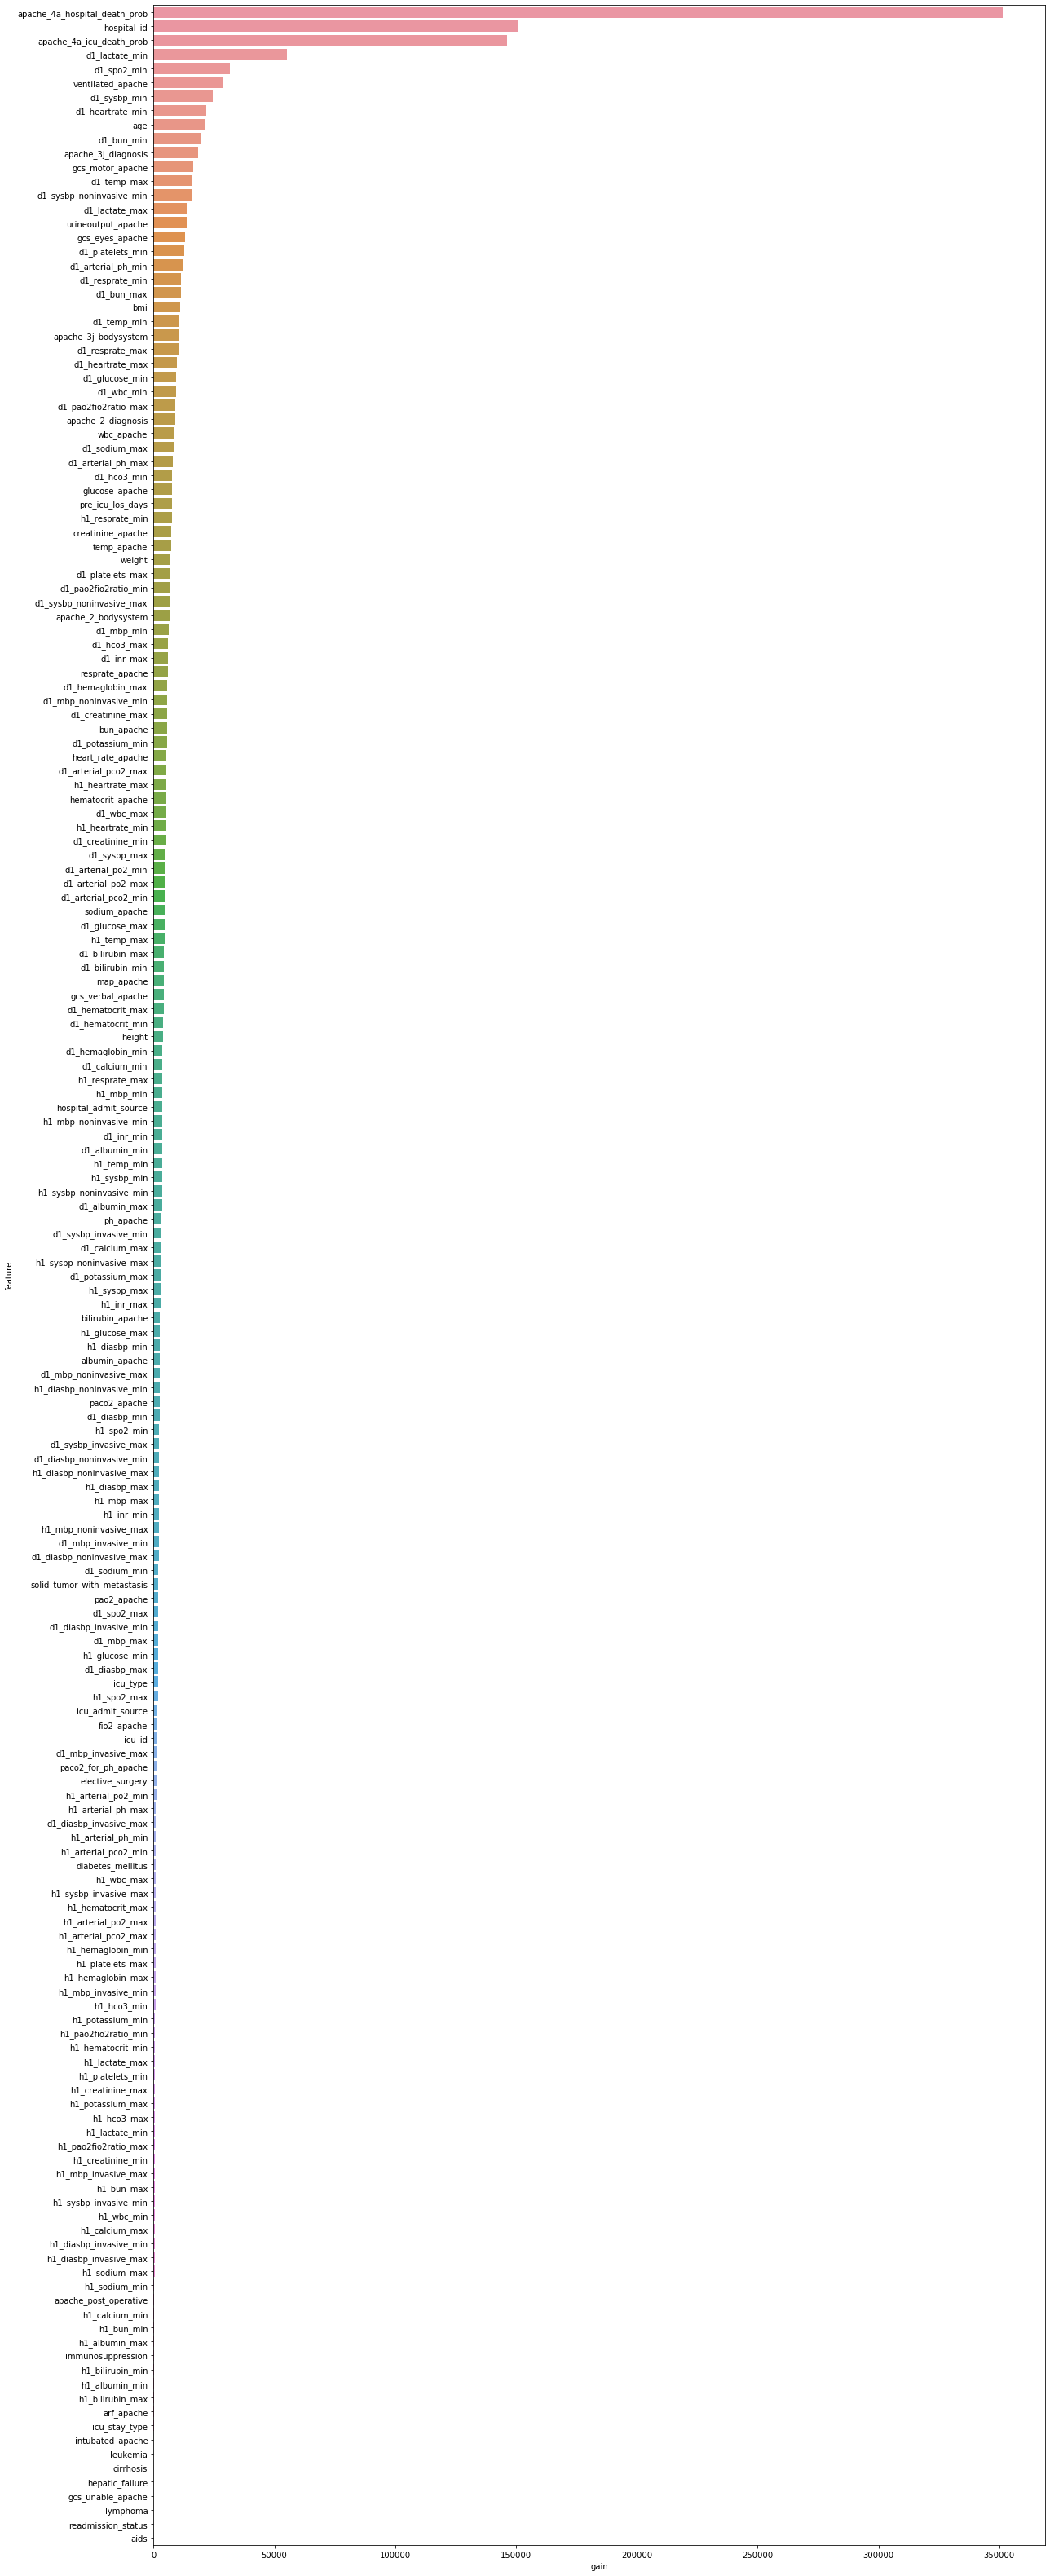

In [21]:
plot_importances(imp_df)

# Feature Importance by permutation importance algo

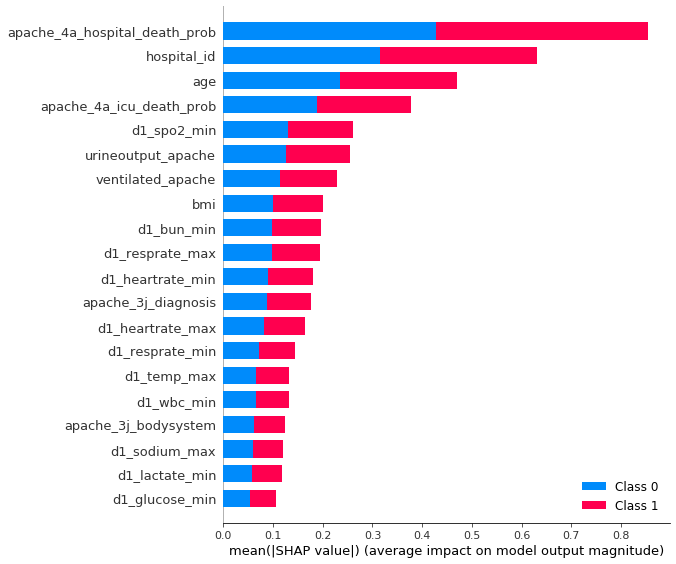

In [24]:
import shap
explainer   =  shap.TreeExplainer(lgb_model.model)
shap_values = explainer.shap_values(train[features].iloc[:1000,:])
shap.summary_plot(shap_values, train[features].iloc[:1000,:])

# Some univariate plot of the best feature

apache_4a_hospital_death_prob 0 gain : 351252.365885973


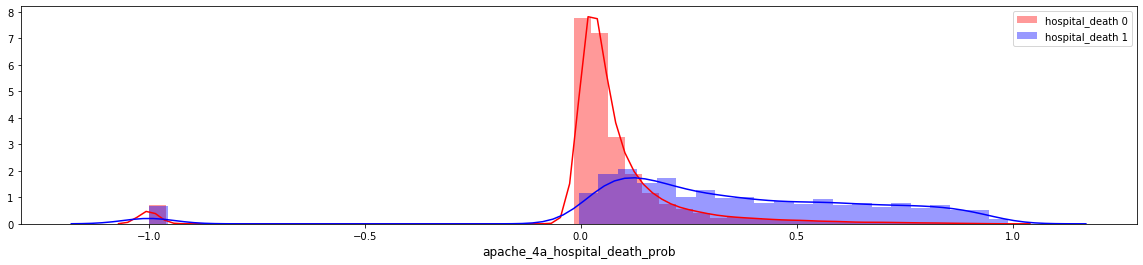

hospital_id 1 gain : 150560.84422779083


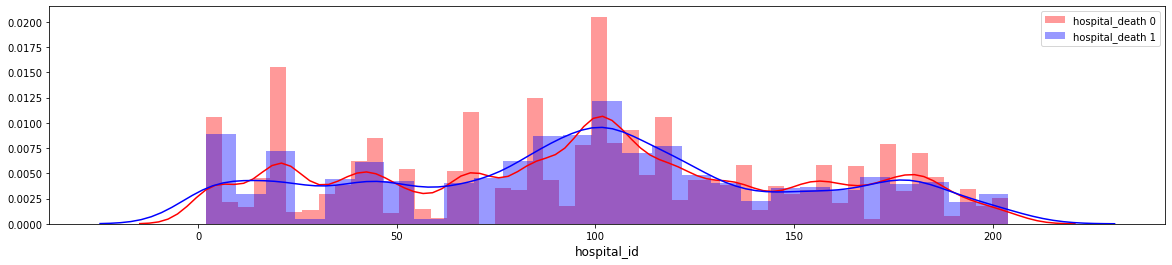

apache_4a_icu_death_prob 2 gain : 146275.1173324585


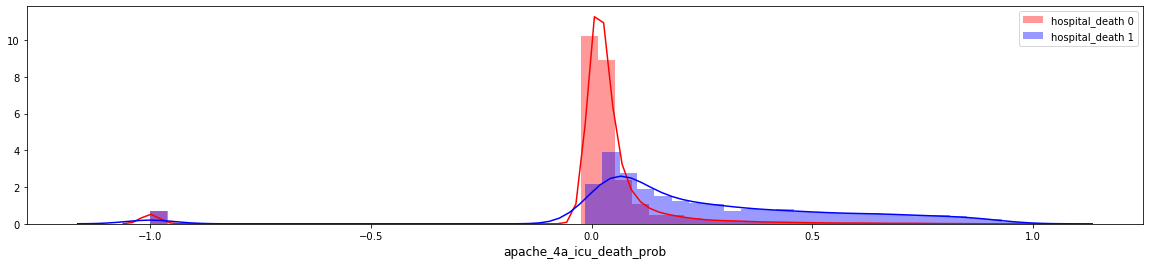

d1_lactate_min 3 gain : 55353.86215758324


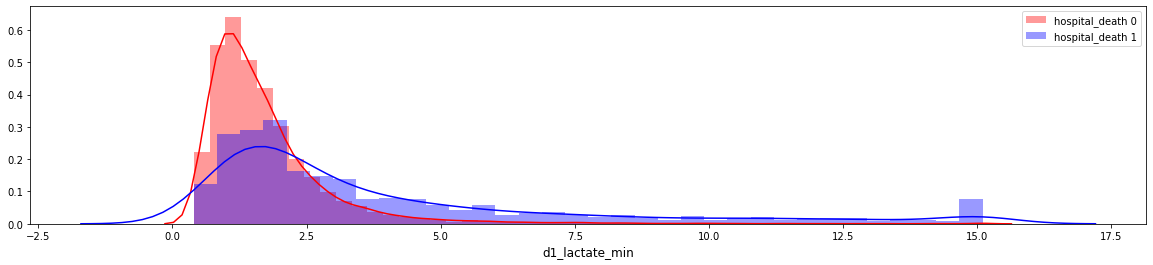

d1_spo2_min 4 gain : 31732.761485099792


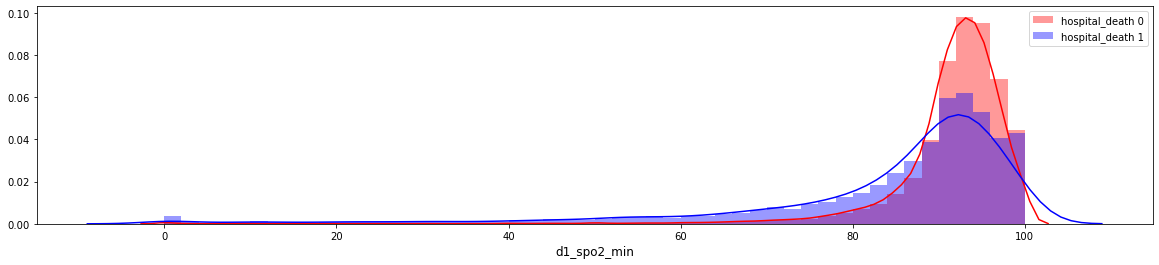

ventilated_apache 5 gain : 28691.33399581909


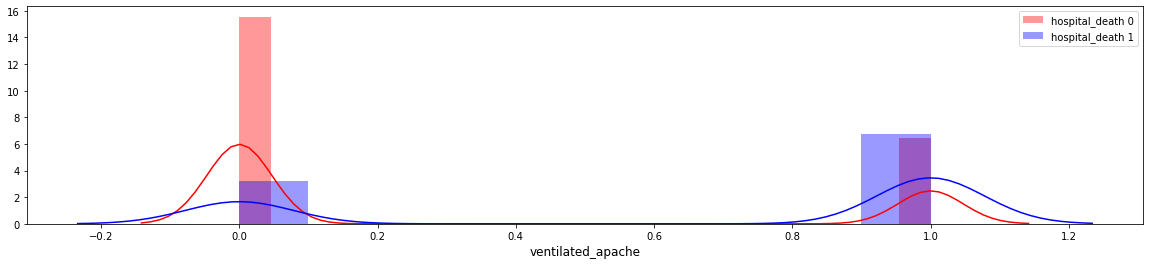

d1_sysbp_min 6 gain : 24419.43428516388


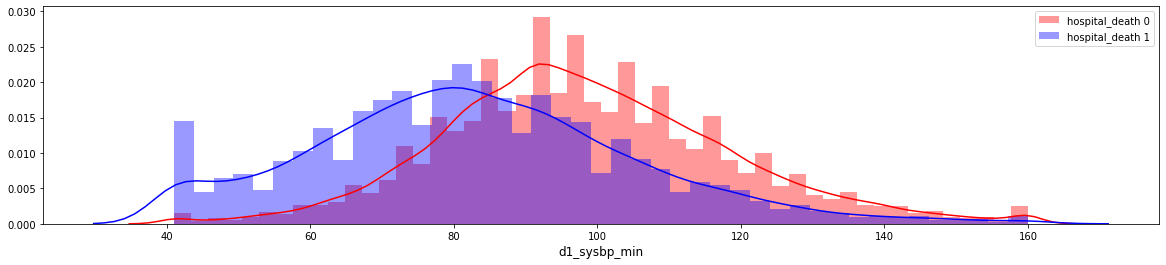

d1_heartrate_min 7 gain : 21757.668104171753


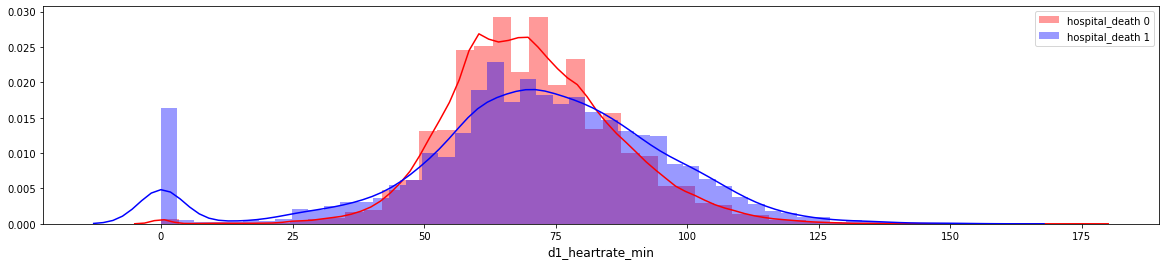

age 8 gain : 21481.372059106827


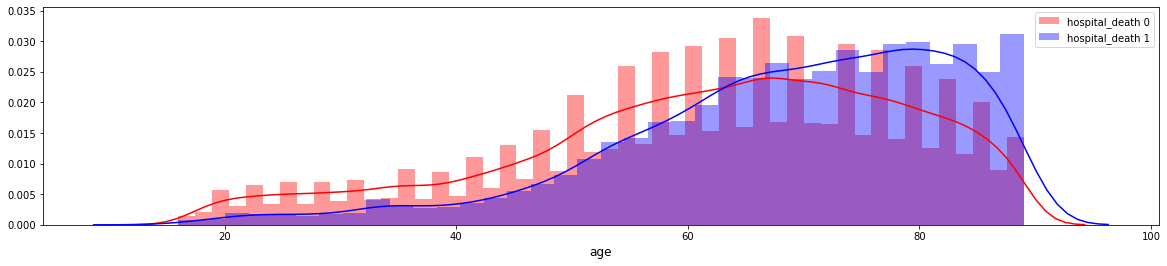

d1_bun_min 9 gain : 19529.879061460495


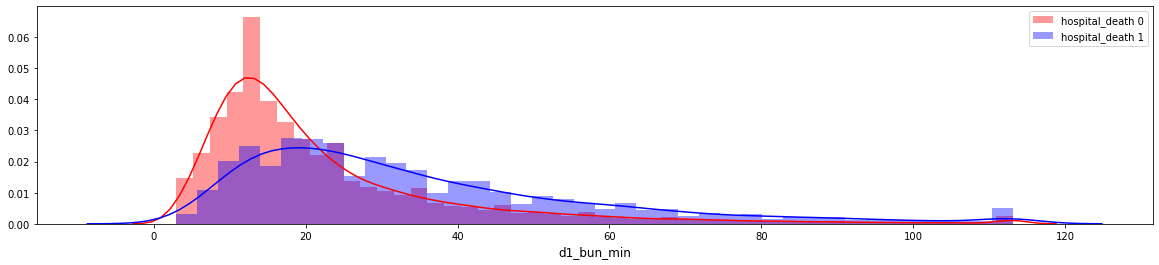

apache_3j_diagnosis 10 gain : 18576.375860452652


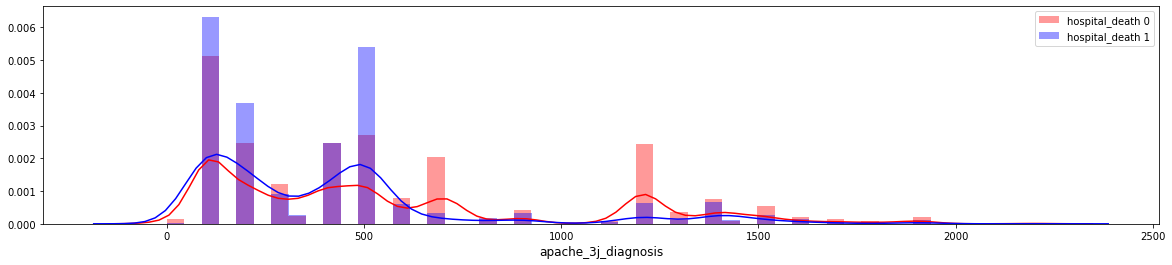

gcs_motor_apache 11 gain : 16573.00981283188


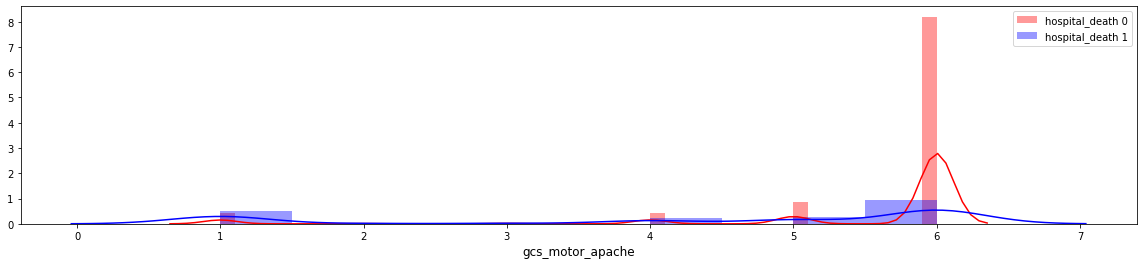

d1_temp_max 12 gain : 16168.361726999283


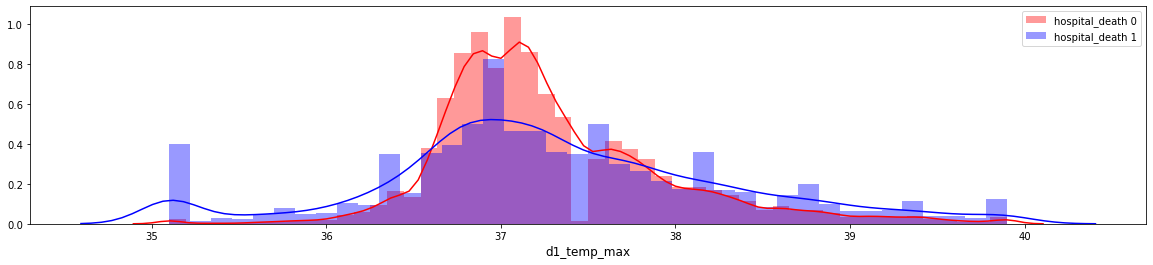

d1_sysbp_noninvasive_min 13 gain : 16028.458354949951


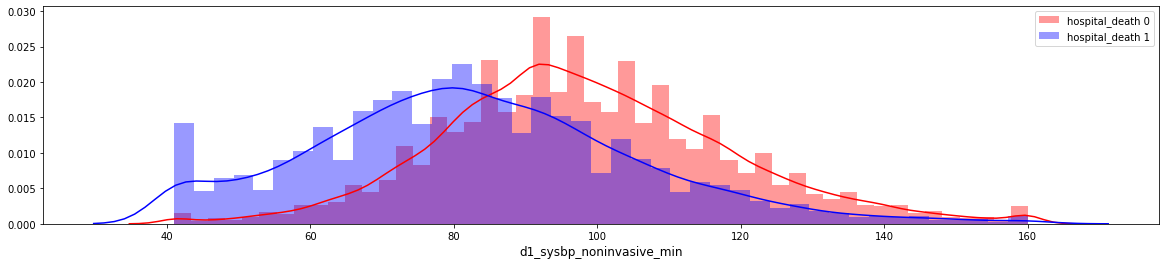

d1_lactate_max 14 gain : 14038.338047266006


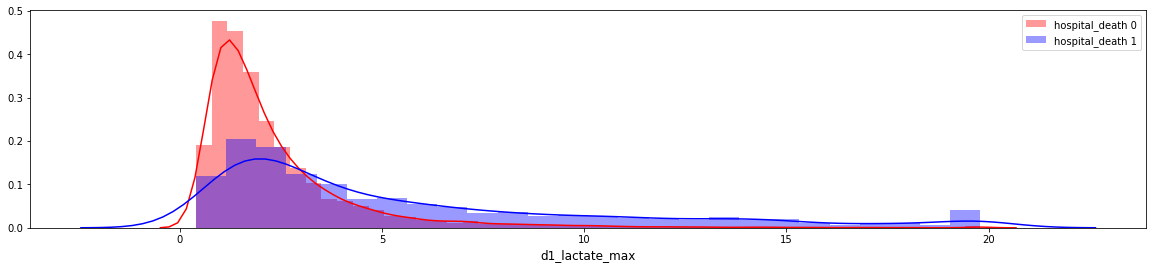

urineoutput_apache 15 gain : 13783.985323429108


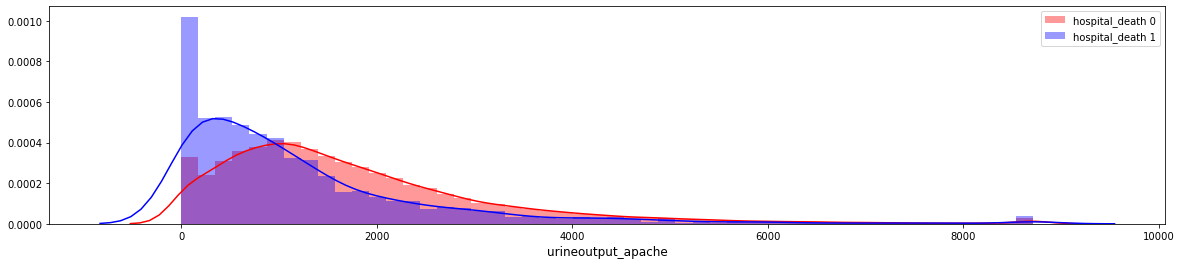

gcs_eyes_apache 16 gain : 13053.265293121338


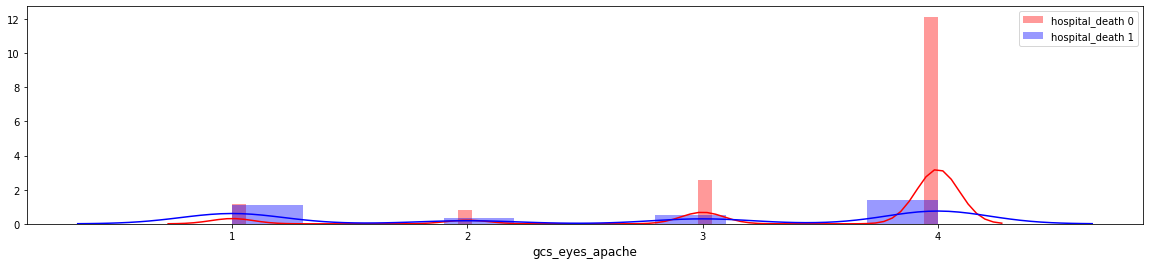

d1_platelets_min 17 gain : 12857.688428878784


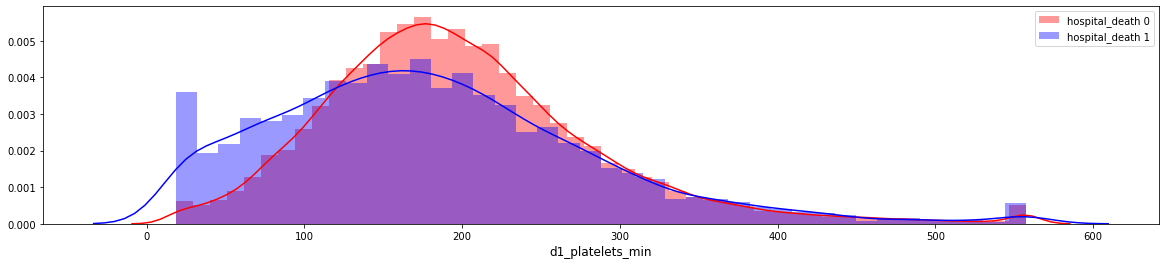

d1_arterial_ph_min 18 gain : 12081.881103992462


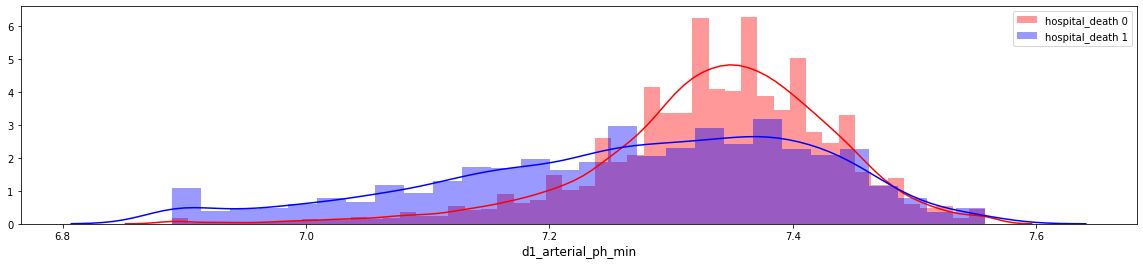

d1_resprate_min 19 gain : 11519.11014342308


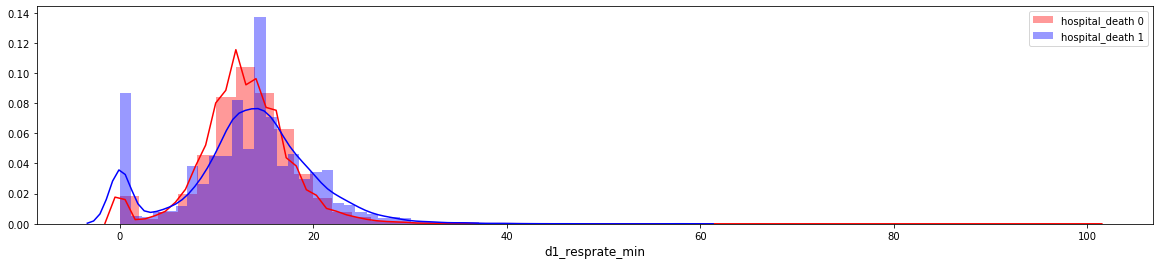

d1_bun_max 20 gain : 11254.286282539368


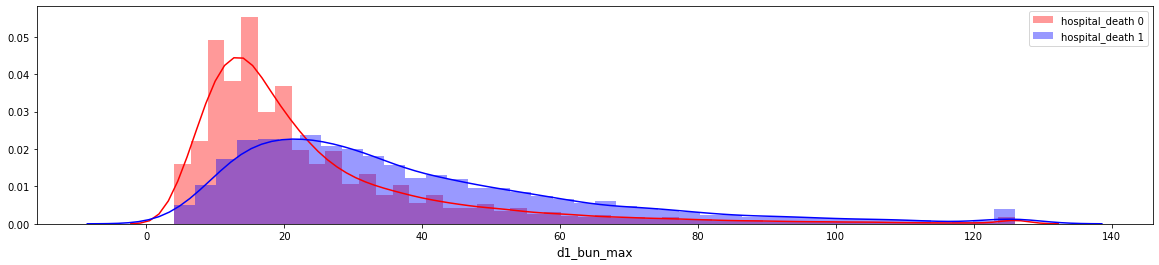

bmi 21 gain : 10985.150521993637


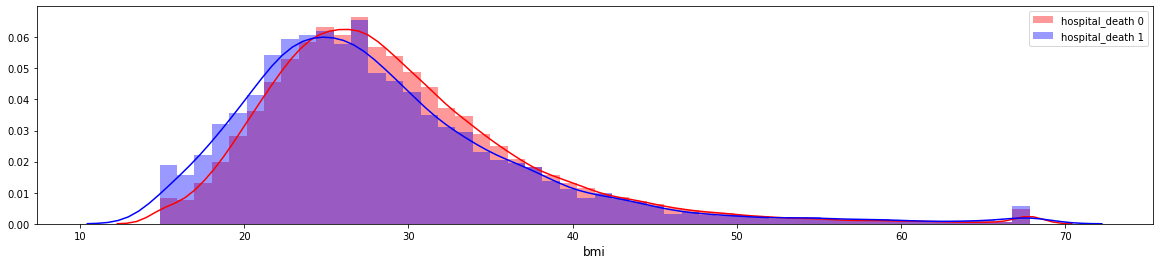

d1_temp_min 22 gain : 10853.892260551453


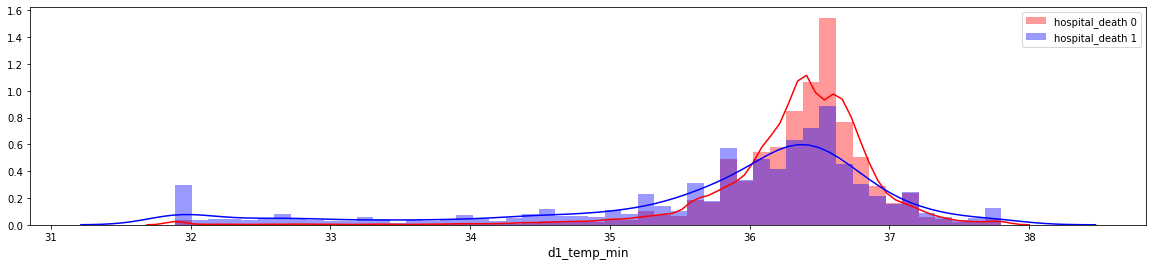

apache_3j_bodysystem 23 gain : 10575.751663684845


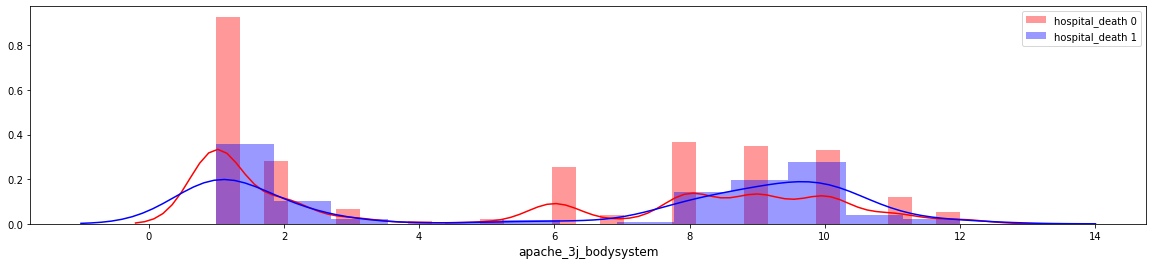

d1_resprate_max 24 gain : 10320.771817922592


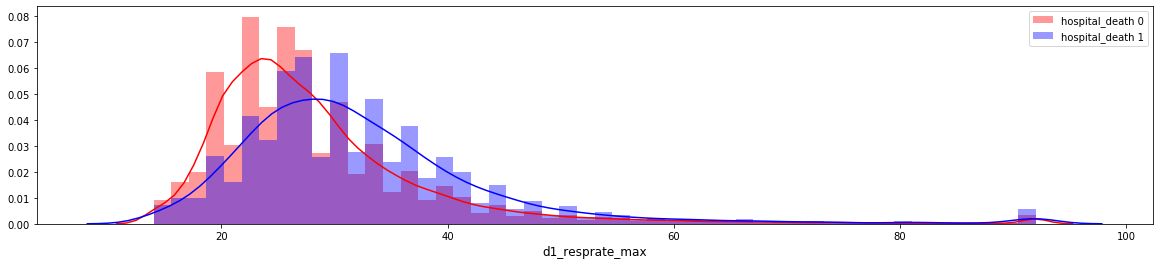

d1_heartrate_max 25 gain : 9808.910019397736


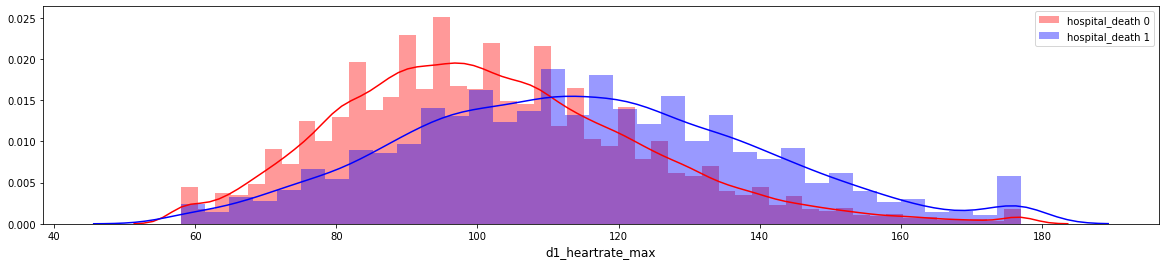

d1_glucose_min 26 gain : 9175.222955703735


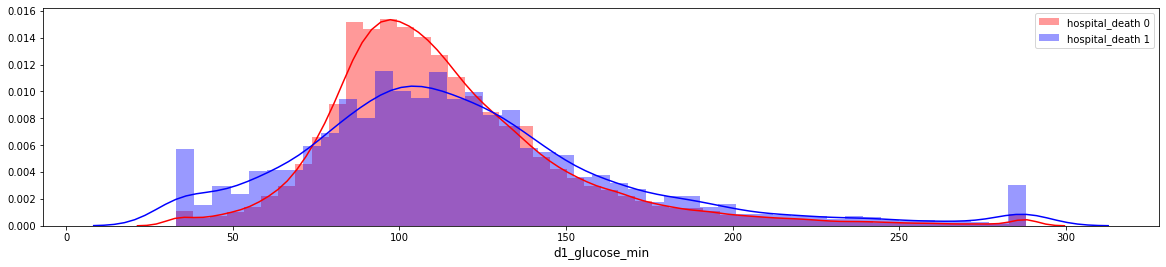

d1_wbc_min 27 gain : 9171.61188173294


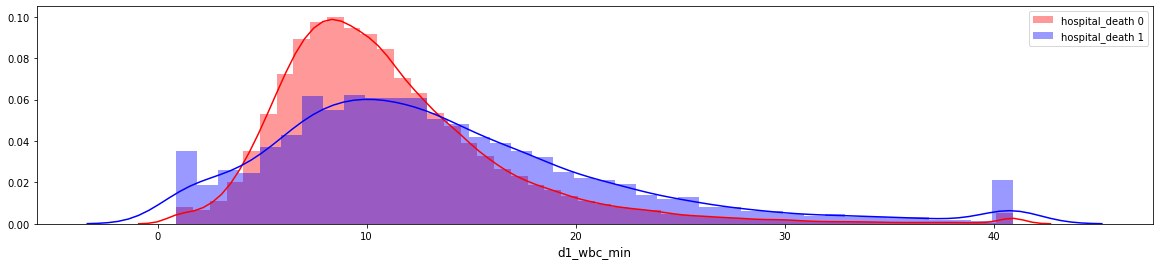

d1_pao2fio2ratio_max 28 gain : 8934.969403982162


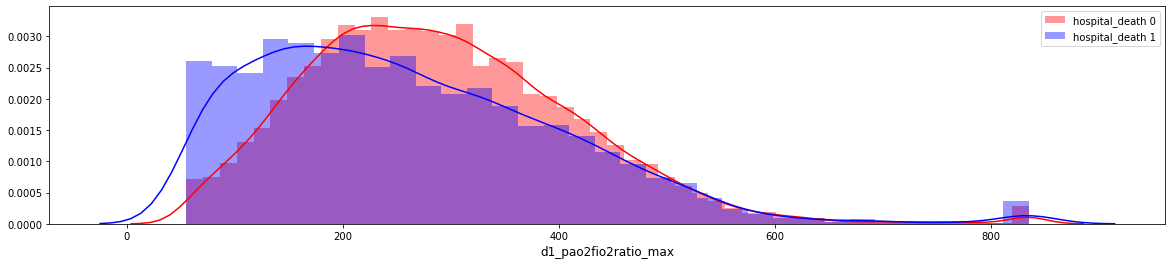

apache_2_diagnosis 29 gain : 8857.88154411316


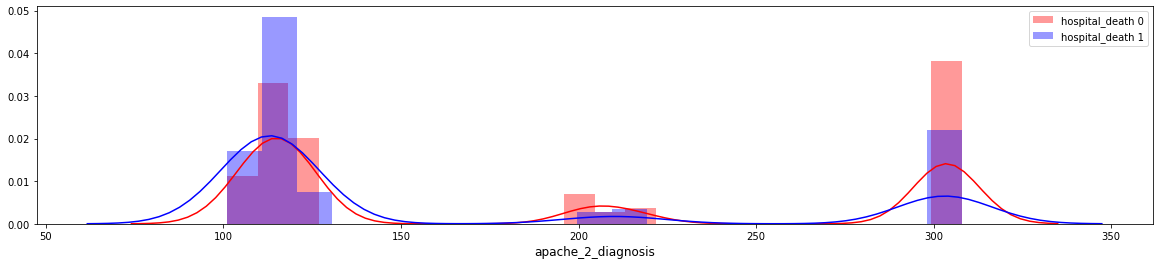

wbc_apache 30 gain : 8504.452875375748


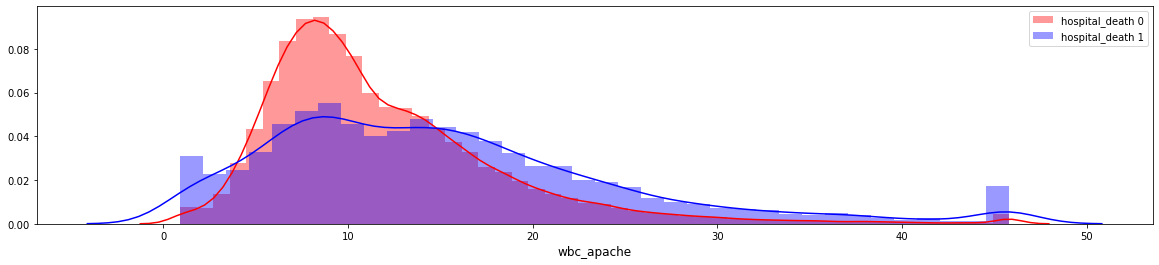

d1_sodium_max 31 gain : 8418.125189781189


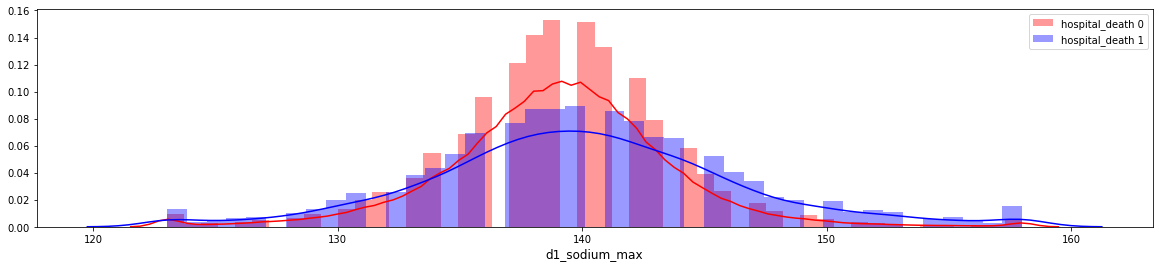

d1_arterial_ph_max 32 gain : 7989.068685293198


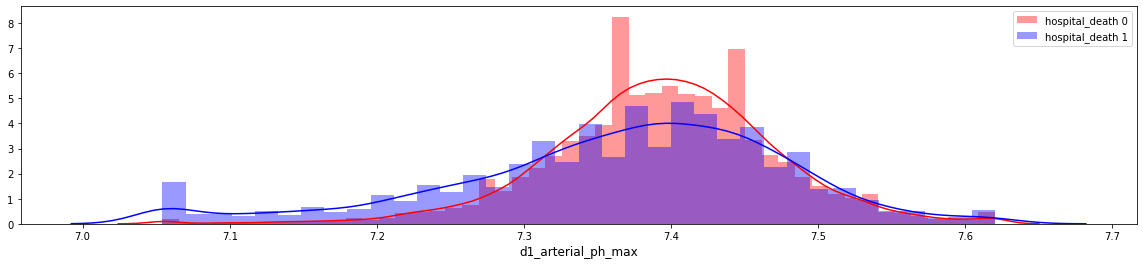

d1_hco3_min 33 gain : 7691.476171255112


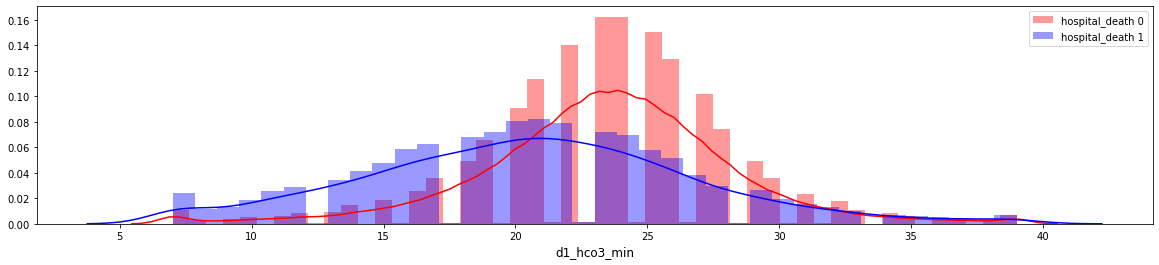

glucose_apache 34 gain : 7641.672451019287


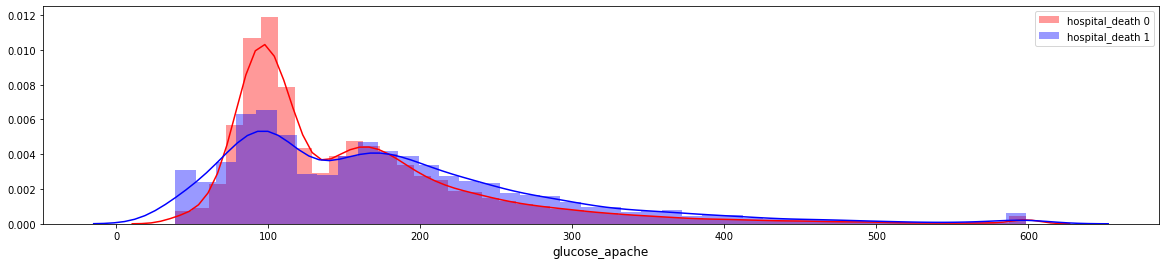

pre_icu_los_days 35 gain : 7494.74694108963


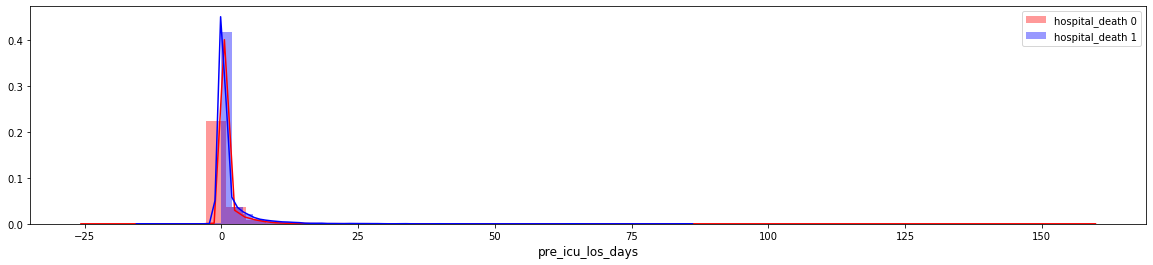

h1_resprate_min 36 gain : 7485.923817396164


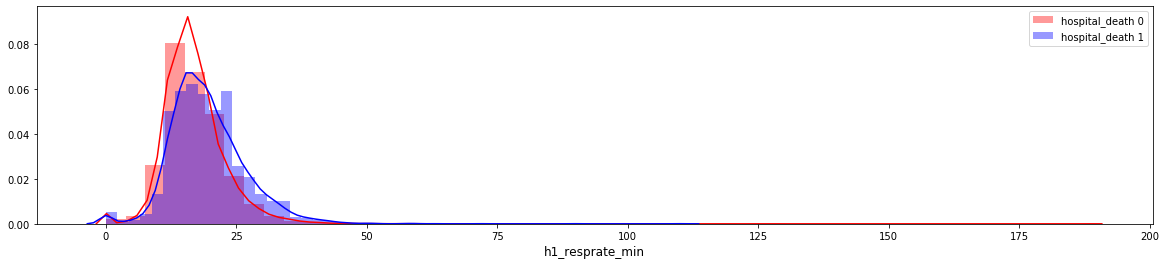

creatinine_apache 37 gain : 7413.3983066082


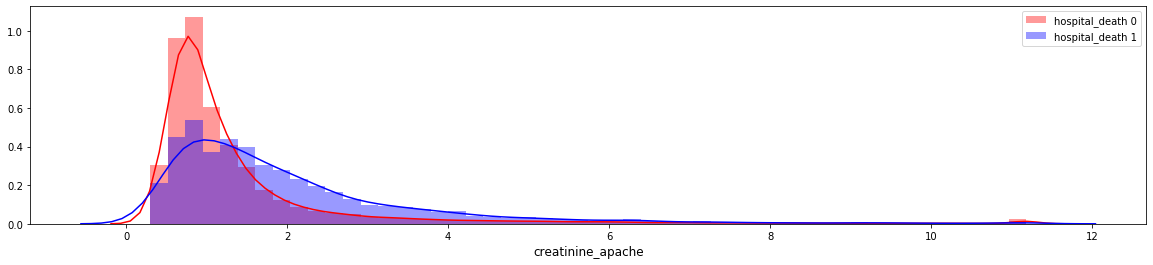

temp_apache 38 gain : 7281.159093618393


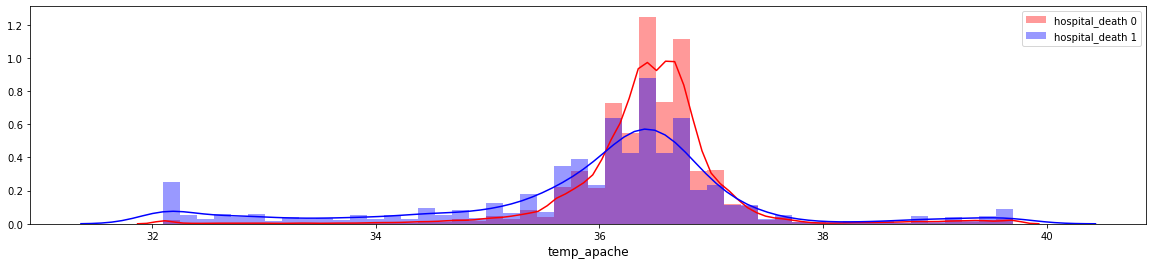

weight 39 gain : 6915.9319133758545


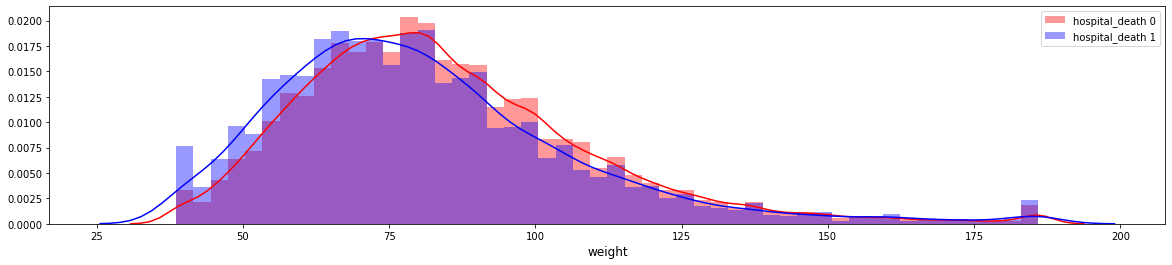

d1_platelets_max 40 gain : 6849.855688333511


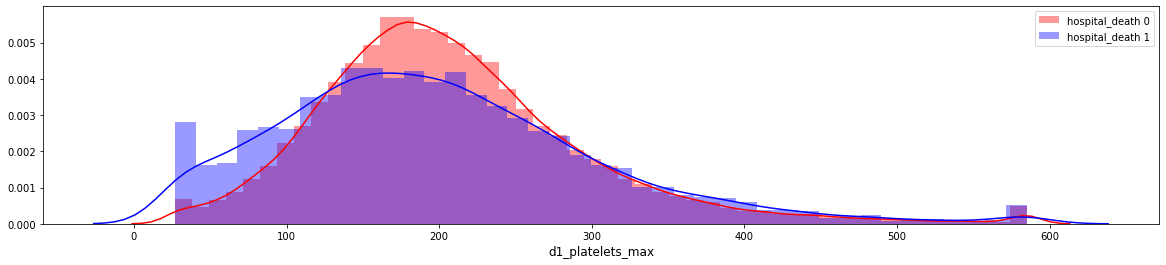

d1_pao2fio2ratio_min 41 gain : 6763.60645365715


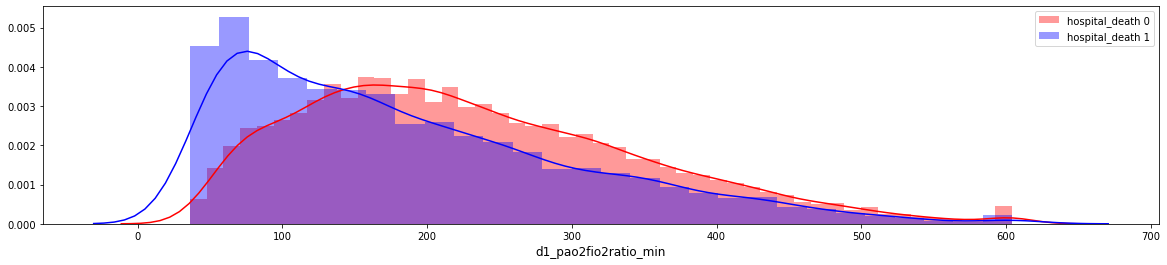

d1_sysbp_noninvasive_max 42 gain : 6714.262719631195


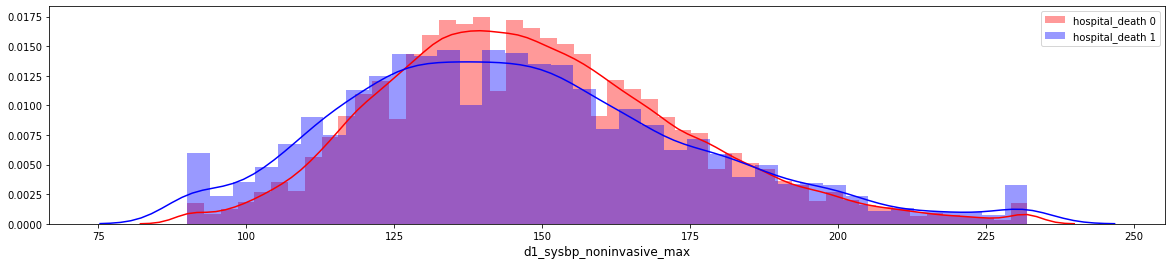

apache_2_bodysystem 43 gain : 6507.397555351257


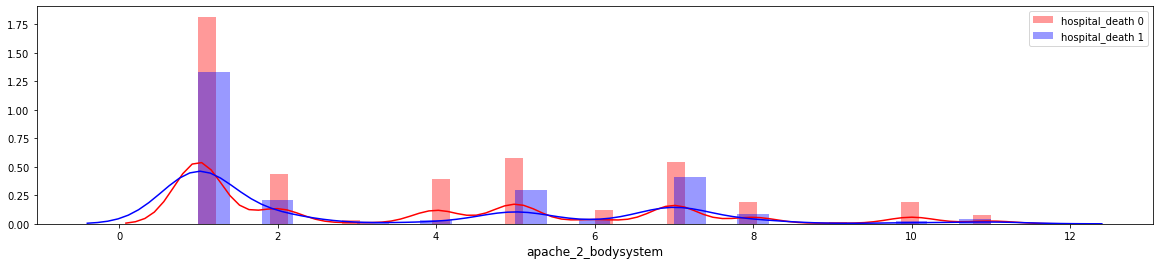

d1_mbp_min 44 gain : 6398.961150884628


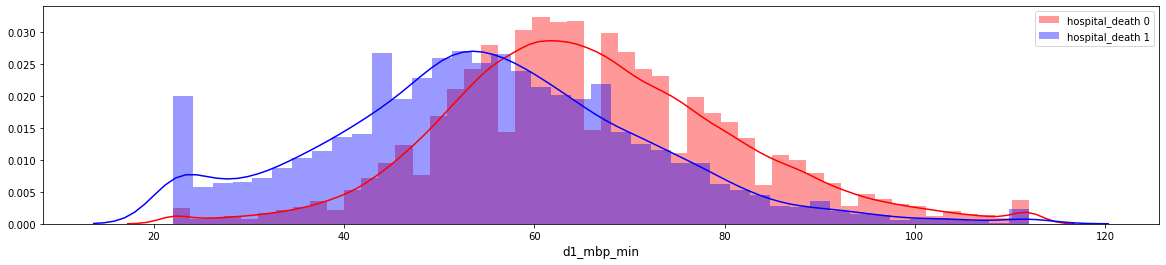

d1_hco3_max 45 gain : 6097.269358158112


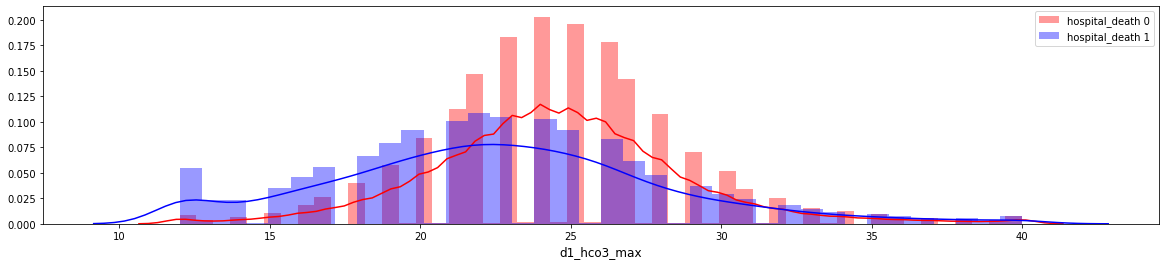

d1_inr_max 46 gain : 5984.607861280441


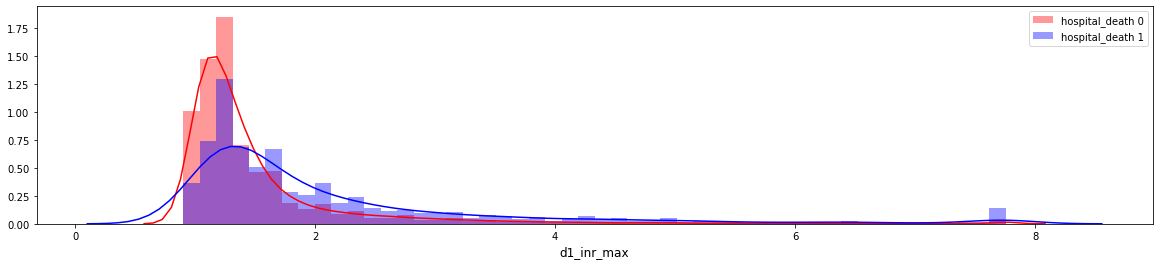

resprate_apache 47 gain : 5856.124365568161


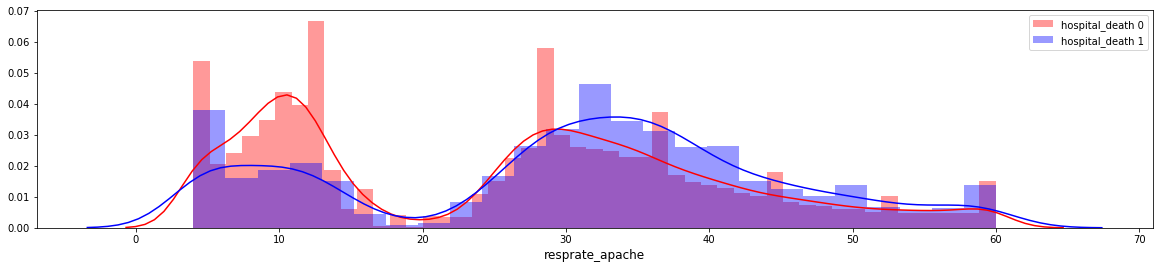

d1_hemaglobin_max 48 gain : 5758.485659599304


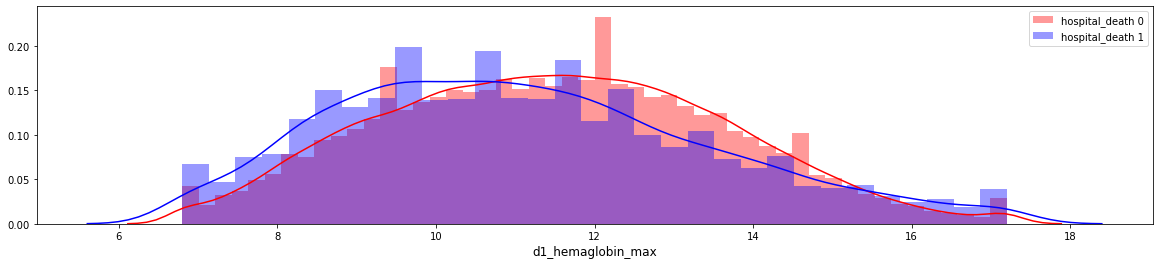

d1_mbp_noninvasive_min 49 gain : 5615.044913053513


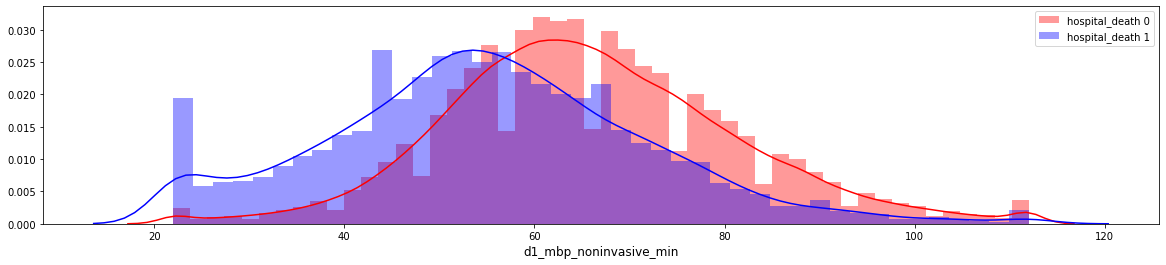

In [38]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
i=0
for index, row in imp_df.sort_values(by=['gain'],ascending=False).iterrows():  
    column=row['feature']
    if i< 50:
            print(column,i,"gain :",row['gain'])
            df1      = train.loc[train['hospital_death']==0]
            df2      = train.loc[train['hospital_death']==1]

            fig = plt.figure(figsize=(20,4))
            sns.distplot(df1[column].dropna(),  color='red', label='hospital_death 0', kde=True); 
            sns.distplot(df2[column].dropna(),  color='blue', label='hospital_death 1', kde=True); 
            fig=plt.legend(loc='best')
            plt.xlabel(column, fontsize=12);
            plt.show()
            i=i+1


## Feature Selection

In [27]:
# Find the features with zero importance

imp_df_sorted = imp_df.sort_values('gain', ascending = False)

zero_features = list(imp_df_sorted[imp_df_sorted['gain'] == 0.0]['feature'])

print('There are %d features with 0.0 importance' % len(zero_features))
imp_df_sorted.tail()

# Drop features with zero importance
print('\nLength train features: {}'.format(len(features)))
for feat_to_remove in zero_features:
    print('Removing....{}'.format(feat_to_remove))
    features.remove(feat_to_remove)

print('\nNew length train features: {}'.format(len(features)))    

There are 4 features with 0.0 importance
Length train features: 181
Removing....gcs_unable_apache
Removing....lymphoma
Removing....readmission_status
Removing....aids
New length train features: 177


## New Model with Feature Selection and Parametes Tuning

In [28]:
# Hyper parameter tuning

boll_BayesianOptimization = True

In [31]:
# ACTIVATE it if you want to search for better parameter
if boll_BayesianOptimization: 
    LGB_BO_v2 = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
    import warnings
    init_points = 16
    n_iter = 16
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO_v2.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | scale_... | subsam... |
-------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.915745	valid_1's auc: 0.894274
[200]	training's auc: 0.929449	valid_1's auc: 0.900922
[300]	training's auc: 0.939118	valid_1's auc: 0.903915
[400]	training's auc: 0.947524	valid_1's auc: 0.905663
[500]	training's auc: 0.954915	valid_1's auc: 0.906699
[600]	training's auc: 0.96086	valid_1's auc: 0.907443
[700]	training's auc: 0.966165	valid_1's auc: 0.907972
[800]	training's auc: 0.970688	valid_1's auc: 0.908426
[900]	training's auc: 0.974693	valid_1's auc: 0.908501
[1000]	training's auc: 0.978114	valid_1's auc: 0.908663
[1100]	training's auc: 0.981027	valid_1's auc: 0.908922
[1200]	training's auc: 0.983655	valid_1's auc: 0.9089
[1300]	training's auc: 0.985891	valid_1's auc: 0.908956
Ea

[1300]	training's auc: 0.979433	valid_1's auc: 0.905383
Early stopping, best iteration is:
[1284]	training's auc: 0.979044	valid_1's auc: 0.90546
Partial score of fold 3 is: 0.905459647425656
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.91239	valid_1's auc: 0.88693
[200]	training's auc: 0.925685	valid_1's auc: 0.895365
[300]	training's auc: 0.934726	valid_1's auc: 0.899883
[400]	training's auc: 0.942211	valid_1's auc: 0.90197
[500]	training's auc: 0.948543	valid_1's auc: 0.903245
[600]	training's auc: 0.953941	valid_1's auc: 0.904119
[700]	training's auc: 0.959045	valid_1's auc: 0.905019
[800]	training's auc: 0.96351	valid_1's auc: 0.905626
[900]	training's auc: 0.967563	valid_1's auc: 0.906019
[1000]	training's auc: 0.970928	valid_1's auc: 0.906479
[1100]	training's auc: 0.973787	valid_1's auc: 0.906618
[1200]	training's auc: 0.976549	valid_1's auc: 0.906762
[1300]	training's auc: 0.979084	valid_1's auc: 0.906981
[1400]	training's auc: 0.981339

[600]	training's auc: 0.961828	valid_1's auc: 0.904211
[700]	training's auc: 0.966678	valid_1's auc: 0.904611
[800]	training's auc: 0.970928	valid_1's auc: 0.9048
[900]	training's auc: 0.974415	valid_1's auc: 0.905195
[1000]	training's auc: 0.977447	valid_1's auc: 0.905665
[1100]	training's auc: 0.980154	valid_1's auc: 0.905634
Early stopping, best iteration is:
[1065]	training's auc: 0.979239	valid_1's auc: 0.905733
Partial score of fold 0 is: 0.9057328989245821
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.917697	valid_1's auc: 0.885852
[200]	training's auc: 0.932627	valid_1's auc: 0.894352
[300]	training's auc: 0.942454	valid_1's auc: 0.898454
[400]	training's auc: 0.950239	valid_1's auc: 0.900105
[500]	training's auc: 0.956845	valid_1's auc: 0.901149
[600]	training's auc: 0.962488	valid_1's auc: 0.902108
[700]	training's auc: 0.967313	valid_1's auc: 0.902437
[800]	training's auc: 0.971372	valid_1's auc: 0.902628
[900]	training's auc: 0.974875

[1700]	training's auc: 0.980353	valid_1's auc: 0.903695
[1800]	training's auc: 0.981916	valid_1's auc: 0.90354
Early stopping, best iteration is:
[1702]	training's auc: 0.980391	valid_1's auc: 0.903698
Partial score of fold 3 is: 0.9036978725981876
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.909524	valid_1's auc: 0.884025
[200]	training's auc: 0.921531	valid_1's auc: 0.890292
[300]	training's auc: 0.930467	valid_1's auc: 0.895962
[400]	training's auc: 0.937065	valid_1's auc: 0.899065
[500]	training's auc: 0.942788	valid_1's auc: 0.901071
[600]	training's auc: 0.94781	valid_1's auc: 0.901922
[700]	training's auc: 0.952249	valid_1's auc: 0.902944
[800]	training's auc: 0.956235	valid_1's auc: 0.903625
[900]	training's auc: 0.960056	valid_1's auc: 0.903962
[1000]	training's auc: 0.963273	valid_1's auc: 0.904411
[1100]	training's auc: 0.966322	valid_1's auc: 0.904777
[1200]	training's auc: 0.969143	valid_1's auc: 0.90496
[1300]	training's auc: 0.971

[1500]	training's auc: 0.974417	valid_1's auc: 0.902174
[1600]	training's auc: 0.976354	valid_1's auc: 0.902315
[1700]	training's auc: 0.978118	valid_1's auc: 0.90235
Early stopping, best iteration is:
[1685]	training's auc: 0.977871	valid_1's auc: 0.902373
Partial score of fold 2 is: 0.9023727266285428
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.910938	valid_1's auc: 0.887987
[200]	training's auc: 0.921307	valid_1's auc: 0.892677
[300]	training's auc: 0.929551	valid_1's auc: 0.896324
[400]	training's auc: 0.936153	valid_1's auc: 0.898571
[500]	training's auc: 0.941589	valid_1's auc: 0.900288
[600]	training's auc: 0.946379	valid_1's auc: 0.901567
[700]	training's auc: 0.950608	valid_1's auc: 0.902303
[800]	training's auc: 0.95472	valid_1's auc: 0.902869
[900]	training's auc: 0.958453	valid_1's auc: 0.903298
[1000]	training's auc: 0.961768	valid_1's auc: 0.903727
[1100]	training's auc: 0.964754	valid_1's auc: 0.904069
[1200]	training's auc: 0.96

[900]	training's auc: 0.953109	valid_1's auc: 0.902347
[1000]	training's auc: 0.95619	valid_1's auc: 0.902957
[1100]	training's auc: 0.959107	valid_1's auc: 0.903363
[1200]	training's auc: 0.961784	valid_1's auc: 0.90381
[1300]	training's auc: 0.964306	valid_1's auc: 0.904082
[1400]	training's auc: 0.966555	valid_1's auc: 0.904213
[1500]	training's auc: 0.968699	valid_1's auc: 0.904434
[1600]	training's auc: 0.970688	valid_1's auc: 0.904517
[1700]	training's auc: 0.972563	valid_1's auc: 0.904712
[1800]	training's auc: 0.974206	valid_1's auc: 0.904915
[1900]	training's auc: 0.975766	valid_1's auc: 0.905044
[2000]	training's auc: 0.977215	valid_1's auc: 0.905078
[2100]	training's auc: 0.978628	valid_1's auc: 0.905125
[2200]	training's auc: 0.979947	valid_1's auc: 0.905255
Early stopping, best iteration is:
[2192]	training's auc: 0.979852	valid_1's auc: 0.905273
Partial score of fold 4 is: 0.9052725726386746
Our oof AUC score is:  0.9036389707541601
auc:  0.9036389707541601
|  8        | 

[800]	training's auc: 0.967936	valid_1's auc: 0.902611
[900]	training's auc: 0.971614	valid_1's auc: 0.902996
[1000]	training's auc: 0.97475	valid_1's auc: 0.903265
[1100]	training's auc: 0.977564	valid_1's auc: 0.903406
[1200]	training's auc: 0.979957	valid_1's auc: 0.903391
Early stopping, best iteration is:
[1161]	training's auc: 0.979043	valid_1's auc: 0.903523
Partial score of fold 3 is: 0.9035227467750332
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.915389	valid_1's auc: 0.884536
[200]	training's auc: 0.929332	valid_1's auc: 0.893679
[300]	training's auc: 0.938955	valid_1's auc: 0.89829
[400]	training's auc: 0.946527	valid_1's auc: 0.900606
[500]	training's auc: 0.952832	valid_1's auc: 0.901984
[600]	training's auc: 0.958306	valid_1's auc: 0.902908
[700]	training's auc: 0.963365	valid_1's auc: 0.903302
[800]	training's auc: 0.967488	valid_1's auc: 0.903618
[900]	training's auc: 0.971204	valid_1's auc: 0.903794
[1000]	training's auc: 0.9744

[700]	training's auc: 0.972772	valid_1's auc: 0.904468
[800]	training's auc: 0.97704	valid_1's auc: 0.904598
[900]	training's auc: 0.980582	valid_1's auc: 0.904695
[1000]	training's auc: 0.983389	valid_1's auc: 0.904433
Early stopping, best iteration is:
[908]	training's auc: 0.980846	valid_1's auc: 0.904723
Partial score of fold 1 is: 0.9047227628879035
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.921915	valid_1's auc: 0.888279
[200]	training's auc: 0.936733	valid_1's auc: 0.895282
[300]	training's auc: 0.947401	valid_1's auc: 0.898367
[400]	training's auc: 0.955936	valid_1's auc: 0.899591
[500]	training's auc: 0.962766	valid_1's auc: 0.900809
[600]	training's auc: 0.968481	valid_1's auc: 0.901337
[700]	training's auc: 0.973332	valid_1's auc: 0.901572
[800]	training's auc: 0.977394	valid_1's auc: 0.901972
[900]	training's auc: 0.980667	valid_1's auc: 0.9021
Early stopping, best iteration is:
[885]	training's auc: 0.980211	valid_1's auc: 0.90218

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.907685	valid_1's auc: 0.890305
[200]	training's auc: 0.919754	valid_1's auc: 0.895815
[300]	training's auc: 0.928694	valid_1's auc: 0.899999
[400]	training's auc: 0.935669	valid_1's auc: 0.902551
[500]	training's auc: 0.94158	valid_1's auc: 0.904156
[600]	training's auc: 0.947046	valid_1's auc: 0.905534
[700]	training's auc: 0.952092	valid_1's auc: 0.906383
[800]	training's auc: 0.95666	valid_1's auc: 0.907206
[900]	training's auc: 0.960705	valid_1's auc: 0.907687
[1000]	training's auc: 0.964291	valid_1's auc: 0.908053
[1100]	training's auc: 0.967646	valid_1's auc: 0.908322
[1200]	training's auc: 0.970728	valid_1's auc: 0.908579
[1300]	training's auc: 0.973502	valid_1's auc: 0.908796
[1400]	training's auc: 0.97593	valid_1's auc: 0.909007
[1500]	training's auc: 0.978109	valid_1's auc: 0.908999
[1600]	training's auc: 0.980117	valid_1's auc: 0.909053
Early stopping, best iteration is:
[1592]	training's a

[900]	training's auc: 0.973566	valid_1's auc: 0.904175
Early stopping, best iteration is:
[804]	training's auc: 0.970092	valid_1's auc: 0.904349
Partial score of fold 3 is: 0.9043488838103488
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.917678	valid_1's auc: 0.889404
[200]	training's auc: 0.930807	valid_1's auc: 0.897689
[300]	training's auc: 0.940619	valid_1's auc: 0.901919
[400]	training's auc: 0.948251	valid_1's auc: 0.904054
[500]	training's auc: 0.955	valid_1's auc: 0.905318
[600]	training's auc: 0.960607	valid_1's auc: 0.90644
[700]	training's auc: 0.965723	valid_1's auc: 0.907052
[800]	training's auc: 0.969917	valid_1's auc: 0.907207
[900]	training's auc: 0.973634	valid_1's auc: 0.907356
[1000]	training's auc: 0.976784	valid_1's auc: 0.907542
[1100]	training's auc: 0.979519	valid_1's auc: 0.907441
Early stopping, best iteration is:
[1044]	training's auc: 0.97801	valid_1's auc: 0.907665
Partial score of fold 4 is: 0.9076650416704095
Our oo

[2100]	training's auc: 0.964532	valid_1's auc: 0.90599
[2200]	training's auc: 0.966011	valid_1's auc: 0.906046
[2300]	training's auc: 0.967435	valid_1's auc: 0.906135
[2400]	training's auc: 0.968822	valid_1's auc: 0.906156
Early stopping, best iteration is:
[2347]	training's auc: 0.968086	valid_1's auc: 0.9062
Partial score of fold 3 is: 0.9061996916111904
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.903971	valid_1's auc: 0.884625
[200]	training's auc: 0.911049	valid_1's auc: 0.888119
[300]	training's auc: 0.916762	valid_1's auc: 0.891722
[400]	training's auc: 0.921667	valid_1's auc: 0.894725
[500]	training's auc: 0.925957	valid_1's auc: 0.897742
[600]	training's auc: 0.929701	valid_1's auc: 0.89978
[700]	training's auc: 0.93308	valid_1's auc: 0.901282
[800]	training's auc: 0.936171	valid_1's auc: 0.902531
[900]	training's auc: 0.939023	valid_1's auc: 0.903475
[1000]	training's auc: 0.941683	valid_1's auc: 0.904301
[1100]	training's auc: 0.94428

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.902582	valid_1's auc: 0.885262
[200]	training's auc: 0.918121	valid_1's auc: 0.893365
[300]	training's auc: 0.928334	valid_1's auc: 0.898278
[400]	training's auc: 0.93595	valid_1's auc: 0.901148
[500]	training's auc: 0.942439	valid_1's auc: 0.902767
[600]	training's auc: 0.947923	valid_1's auc: 0.904273
[700]	training's auc: 0.953029	valid_1's auc: 0.905016
[800]	training's auc: 0.95747	valid_1's auc: 0.905439
[900]	training's auc: 0.961444	valid_1's auc: 0.905914
[1000]	training's auc: 0.96501	valid_1's auc: 0.906279
[1100]	training's auc: 0.968227	valid_1's auc: 0.906557
[1200]	training's auc: 0.971367	valid_1's auc: 0.906765
[1300]	training's auc: 0.973933	valid_1's auc: 0.906857
[1400]	training's auc: 0.976334	valid_1's auc: 0.90682
[1500]	training's auc: 0.978708	valid_1's auc: 0.907022
[1600]	training's auc: 0.980652	valid_1's auc: 0.907095
[1700]	training's auc: 0.982426	valid_1's auc: 0.907061

[500]	training's auc: 0.948247	valid_1's auc: 0.902872
[600]	training's auc: 0.953883	valid_1's auc: 0.904011
[700]	training's auc: 0.959631	valid_1's auc: 0.90471
[800]	training's auc: 0.964319	valid_1's auc: 0.905099
[900]	training's auc: 0.968407	valid_1's auc: 0.905139
[1000]	training's auc: 0.971982	valid_1's auc: 0.905762
Early stopping, best iteration is:
[998]	training's auc: 0.971911	valid_1's auc: 0.905787
Partial score of fold 4 is: 0.9057865288588018
Our oof AUC score is:  0.9041121222278096
auc:  0.9041121222278096
|  19       |  0.9041   |  0.9797   |  0.3888   |  4.806    |  0.01515  |  13.54    |  1.038    |  9.881    |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.898044	valid_1's auc: 0.884509
[200]	training's auc: 0.908465	valid_1's auc: 0.890167
[300]	training's auc: 0.916766	valid_1's auc: 0.894674
[400]	training's auc: 0.923793	valid_1's auc: 0.898201
[500]	training's auc: 0.929323	valid_1's auc: 0.900608
[600]	training's au

[2400]	training's auc: 0.978975	valid_1's auc: 0.908123
[2500]	training's auc: 0.98029	valid_1's auc: 0.908202
Early stopping, best iteration is:
[2490]	training's auc: 0.98016	valid_1's auc: 0.908236
Partial score of fold 4 is: 0.9082357271982955
Our oof AUC score is:  0.9067586694393703
auc:  0.9067586694393703
|  20       |  0.9068   |  0.7743   |  0.8008   |  4.974    |  0.008075 |  16.98    |  1.112    |  1.128    |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.909006	valid_1's auc: 0.891416
[200]	training's auc: 0.922713	valid_1's auc: 0.898592
[300]	training's auc: 0.932601	valid_1's auc: 0.902501
[400]	training's auc: 0.940376	valid_1's auc: 0.904835
[500]	training's auc: 0.947121	valid_1's auc: 0.906158
[600]	training's auc: 0.953181	valid_1's auc: 0.907302
[700]	training's auc: 0.958555	valid_1's auc: 0.907784
[800]	training's auc: 0.963175	valid_1's auc: 0.90807
[900]	training's auc: 0.96748	valid_1's auc: 0.908389
[1000]	training's au

Partial score of fold 2 is: 0.9046283830134316
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.904876	valid_1's auc: 0.890882
[200]	training's auc: 0.916394	valid_1's auc: 0.896613
[300]	training's auc: 0.925952	valid_1's auc: 0.900577
[400]	training's auc: 0.933278	valid_1's auc: 0.903102
[500]	training's auc: 0.939244	valid_1's auc: 0.904334
[600]	training's auc: 0.944756	valid_1's auc: 0.905297
[700]	training's auc: 0.949626	valid_1's auc: 0.906067
[800]	training's auc: 0.954111	valid_1's auc: 0.906472
[900]	training's auc: 0.958309	valid_1's auc: 0.90681
[1000]	training's auc: 0.961902	valid_1's auc: 0.90703
[1100]	training's auc: 0.965182	valid_1's auc: 0.907267
[1200]	training's auc: 0.968365	valid_1's auc: 0.907255
[1300]	training's auc: 0.971217	valid_1's auc: 0.90743
[1400]	training's auc: 0.97396	valid_1's auc: 0.907516
Early stopping, best iteration is:
[1354]	training's auc: 0.972755	valid_1's auc: 0.907557
Partial score of fold 3 is: 0

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.907658	valid_1's auc: 0.890755
[200]	training's auc: 0.921588	valid_1's auc: 0.898835
[300]	training's auc: 0.93128	valid_1's auc: 0.902778
[400]	training's auc: 0.938797	valid_1's auc: 0.904983
[500]	training's auc: 0.945603	valid_1's auc: 0.906377
[600]	training's auc: 0.951234	valid_1's auc: 0.907292
[700]	training's auc: 0.956391	valid_1's auc: 0.907766
[800]	training's auc: 0.960759	valid_1's auc: 0.908187
[900]	training's auc: 0.964757	valid_1's auc: 0.908638
[1000]	training's auc: 0.96829	valid_1's auc: 0.908906
[1100]	training's auc: 0.971422	valid_1's auc: 0.909069
[1200]	training's auc: 0.974352	valid_1's auc: 0.909196
[1300]	training's auc: 0.976959	valid_1's auc: 0.909117
Early stopping, best iteration is:
[1214]	training's auc: 0.974746	valid_1's auc: 0.909251
Partial score of fold 0 is: 0.9092513007386055
Training until validation scores don't improve for 100 rounds
[100]	training's auc:

[1100]	training's auc: 0.980586	valid_1's auc: 0.908145
[1200]	training's auc: 0.983449	valid_1's auc: 0.908258
[1300]	training's auc: 0.985859	valid_1's auc: 0.908224
Early stopping, best iteration is:
[1210]	training's auc: 0.983715	valid_1's auc: 0.908322
Partial score of fold 4 is: 0.9083223477625679
Our oof AUC score is:  0.9067660511469412
auc:  0.9067660511469412
|  25       |  0.9068   |  0.7097   |  0.09637  |  4.677    |  0.01887  |  16.92    |  1.107    |  1.024    |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.899358	valid_1's auc: 0.886976
[200]	training's auc: 0.907669	valid_1's auc: 0.891791
[300]	training's auc: 0.914542	valid_1's auc: 0.895347
[400]	training's auc: 0.920361	valid_1's auc: 0.898506
[500]	training's auc: 0.92523	valid_1's auc: 0.900896
[600]	training's auc: 0.929528	valid_1's auc: 0.902815
[700]	training's auc: 0.933281	valid_1's auc: 0.904161
[800]	training's auc: 0.936711	valid_1's auc: 0.905167
[900]	training's

Partial score of fold 4 is: 0.9093215751508595
Our oof AUC score is:  0.9075241899054636
auc:  0.9075241899054636
|  26       |  0.9075   |  0.5242   |  4.172    |  4.644    |  0.007898 |  16.62    |  1.22     |  1.028    |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.908407	valid_1's auc: 0.890321
[200]	training's auc: 0.923382	valid_1's auc: 0.898823
[300]	training's auc: 0.932987	valid_1's auc: 0.902705
[400]	training's auc: 0.940741	valid_1's auc: 0.904898
[500]	training's auc: 0.947469	valid_1's auc: 0.906222
[600]	training's auc: 0.953194	valid_1's auc: 0.907216
[700]	training's auc: 0.958393	valid_1's auc: 0.907814
[800]	training's auc: 0.962843	valid_1's auc: 0.908129
[900]	training's auc: 0.966857	valid_1's auc: 0.908471
[1000]	training's auc: 0.970367	valid_1's auc: 0.908681
[1100]	training's auc: 0.97358	valid_1's auc: 0.908882
[1200]	training's auc: 0.976528	valid_1's auc: 0.908947
[1300]	training's auc: 0.979035	valid_1's auc: 0.908

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.899387	valid_1's auc: 0.880496
[200]	training's auc: 0.906424	valid_1's auc: 0.884556
[300]	training's auc: 0.912652	valid_1's auc: 0.887948
[400]	training's auc: 0.918055	valid_1's auc: 0.89079
[500]	training's auc: 0.922782	valid_1's auc: 0.893557
[600]	training's auc: 0.92681	valid_1's auc: 0.895549
[700]	training's auc: 0.930328	valid_1's auc: 0.896961
[800]	training's auc: 0.933489	valid_1's auc: 0.898086
[900]	training's auc: 0.936437	valid_1's auc: 0.898802
[1000]	training's auc: 0.939137	valid_1's auc: 0.899504
[1100]	training's auc: 0.941755	valid_1's auc: 0.90009
[1200]	training's auc: 0.944228	valid_1's auc: 0.90044
[1300]	training's auc: 0.946574	valid_1's auc: 0.900757
[1400]	training's auc: 0.948792	valid_1's auc: 0.901081
[1500]	training's auc: 0.95093	valid_1's auc: 0.901448
[1600]	training's auc: 0.95301	valid_1's auc: 0.90179
[1700]	training's auc: 0.954975	valid_1's auc: 0.902023
[1

[900]	training's auc: 0.967273	valid_1's auc: 0.906489
Early stopping, best iteration is:
[880]	training's auc: 0.966459	valid_1's auc: 0.906588
Partial score of fold 3 is: 0.9065884664153262
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.908507	valid_1's auc: 0.889904
[200]	training's auc: 0.922099	valid_1's auc: 0.897733
[300]	training's auc: 0.932003	valid_1's auc: 0.902166
[400]	training's auc: 0.939791	valid_1's auc: 0.904581
[500]	training's auc: 0.946591	valid_1's auc: 0.905852
[600]	training's auc: 0.952642	valid_1's auc: 0.90677
[700]	training's auc: 0.957906	valid_1's auc: 0.907341
[800]	training's auc: 0.962536	valid_1's auc: 0.907828
[900]	training's auc: 0.966731	valid_1's auc: 0.908164
[1000]	training's auc: 0.970434	valid_1's auc: 0.908287
[1100]	training's auc: 0.973682	valid_1's auc: 0.90836
[1200]	training's auc: 0.976747	valid_1's auc: 0.908641
[1300]	training's auc: 0.979512	valid_1's auc: 0.908606
Early stopping, best iteratio

[2400]	training's auc: 0.961519	valid_1's auc: 0.904397
Early stopping, best iteration is:
[2348]	training's auc: 0.960793	valid_1's auc: 0.904441
Partial score of fold 3 is: 0.9044406684378524
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.891653	valid_1's auc: 0.877568
[200]	training's auc: 0.899792	valid_1's auc: 0.882898
[300]	training's auc: 0.906243	valid_1's auc: 0.886354
[400]	training's auc: 0.911845	valid_1's auc: 0.889546
[500]	training's auc: 0.916721	valid_1's auc: 0.892351
[600]	training's auc: 0.921275	valid_1's auc: 0.895153
[700]	training's auc: 0.925218	valid_1's auc: 0.897425
[800]	training's auc: 0.928663	valid_1's auc: 0.899087
[900]	training's auc: 0.931684	valid_1's auc: 0.900365
[1000]	training's auc: 0.934446	valid_1's auc: 0.901322
[1100]	training's auc: 0.937012	valid_1's auc: 0.901999
[1200]	training's auc: 0.939412	valid_1's auc: 0.90261
[1300]	training's auc: 0.941649	valid_1's auc: 0.903145
[1400]	training's auc: 0.9

[2000]	training's auc: 0.971253	valid_1's auc: 0.906597
[2100]	training's auc: 0.972965	valid_1's auc: 0.906646
[2200]	training's auc: 0.974538	valid_1's auc: 0.90668
[2300]	training's auc: 0.976014	valid_1's auc: 0.906693
[2400]	training's auc: 0.977385	valid_1's auc: 0.90673
[2500]	training's auc: 0.978802	valid_1's auc: 0.906778
[2600]	training's auc: 0.98002	valid_1's auc: 0.906832
[2700]	training's auc: 0.981179	valid_1's auc: 0.906862
Early stopping, best iteration is:
[2693]	training's auc: 0.981102	valid_1's auc: 0.906884
Partial score of fold 3 is: 0.9068835718973489
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.899114	valid_1's auc: 0.884592
[200]	training's auc: 0.907768	valid_1's auc: 0.889387
[300]	training's auc: 0.915178	valid_1's auc: 0.893431
[400]	training's auc: 0.921782	valid_1's auc: 0.897442
[500]	training's auc: 0.927283	valid_1's auc: 0.900448
[600]	training's auc: 0.931974	valid_1's auc: 0.902337
[700]	training's auc: 0.9

[700]	training's auc: 0.943146	valid_1's auc: 0.902741
[800]	training's auc: 0.947	valid_1's auc: 0.903739
[900]	training's auc: 0.950613	valid_1's auc: 0.904419
[1000]	training's auc: 0.953997	valid_1's auc: 0.904888
[1100]	training's auc: 0.9571	valid_1's auc: 0.905185
[1200]	training's auc: 0.960057	valid_1's auc: 0.905574
[1300]	training's auc: 0.962835	valid_1's auc: 0.905856
[1400]	training's auc: 0.965337	valid_1's auc: 0.906091
[1500]	training's auc: 0.96768	valid_1's auc: 0.906274
[1600]	training's auc: 0.969904	valid_1's auc: 0.906482
[1700]	training's auc: 0.971931	valid_1's auc: 0.906611
[1800]	training's auc: 0.973804	valid_1's auc: 0.906896
[1900]	training's auc: 0.975505	valid_1's auc: 0.906973
[2000]	training's auc: 0.977032	valid_1's auc: 0.90712
[2100]	training's auc: 0.978606	valid_1's auc: 0.90722
Early stopping, best iteration is:
[2067]	training's auc: 0.978098	valid_1's auc: 0.907295
Partial score of fold 4 is: 0.9072954530574024
Our oof AUC score is:  0.90538101

In [32]:
LGB_BO_v2.max['params']

{'feature_fraction': 0.524207414205945,
 'lambda_l1': 4.171808735757517,
 'lambda_l2': 4.6435328298317256,
 'learning_rate': 0.007897539397989824,
 'max_depth': 16.62053004755999,
 'scale_pos_weight': 1.2199266532301127,
 'subsample_freq': 1.0276518730971627}

In [33]:
if boll_BayesianOptimization: # ACTIVATE it if you want to search/use for better parameter
    lgb_model_v2 = Lgb_Model(train,test, features, categoricals=categoricals_features, ps= LGB_BO_v2.max['params'])
else :
    lgb_model_v2 = Lgb_Model(train,test, features, categoricals=categoricals_features, ps=params)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.899358	valid_1's auc: 0.886976
[200]	training's auc: 0.907669	valid_1's auc: 0.891791
[300]	training's auc: 0.914542	valid_1's auc: 0.895347
[400]	training's auc: 0.920361	valid_1's auc: 0.898506
[500]	training's auc: 0.92523	valid_1's auc: 0.900896
[600]	training's auc: 0.929528	valid_1's auc: 0.902815
[700]	training's auc: 0.933281	valid_1's auc: 0.904161
[800]	training's auc: 0.936711	valid_1's auc: 0.905167
[900]	training's auc: 0.939914	valid_1's auc: 0.905877
[1000]	training's auc: 0.942914	valid_1's auc: 0.906541
[1100]	training's auc: 0.945717	valid_1's auc: 0.906978
[1200]	training's auc: 0.948436	valid_1's auc: 0.907454
[1300]	training's auc: 0.950997	valid_1's auc: 0.907894
[1400]	training's auc: 0.953357	valid_1's auc: 0.90822
[1500]	training's auc: 0.955656	valid_1's auc: 0.90851
[1600]	training's auc: 0.957823	valid_1's auc: 0.90876
[1700]	training's auc: 0.959913	valid_1's auc: 0.908919

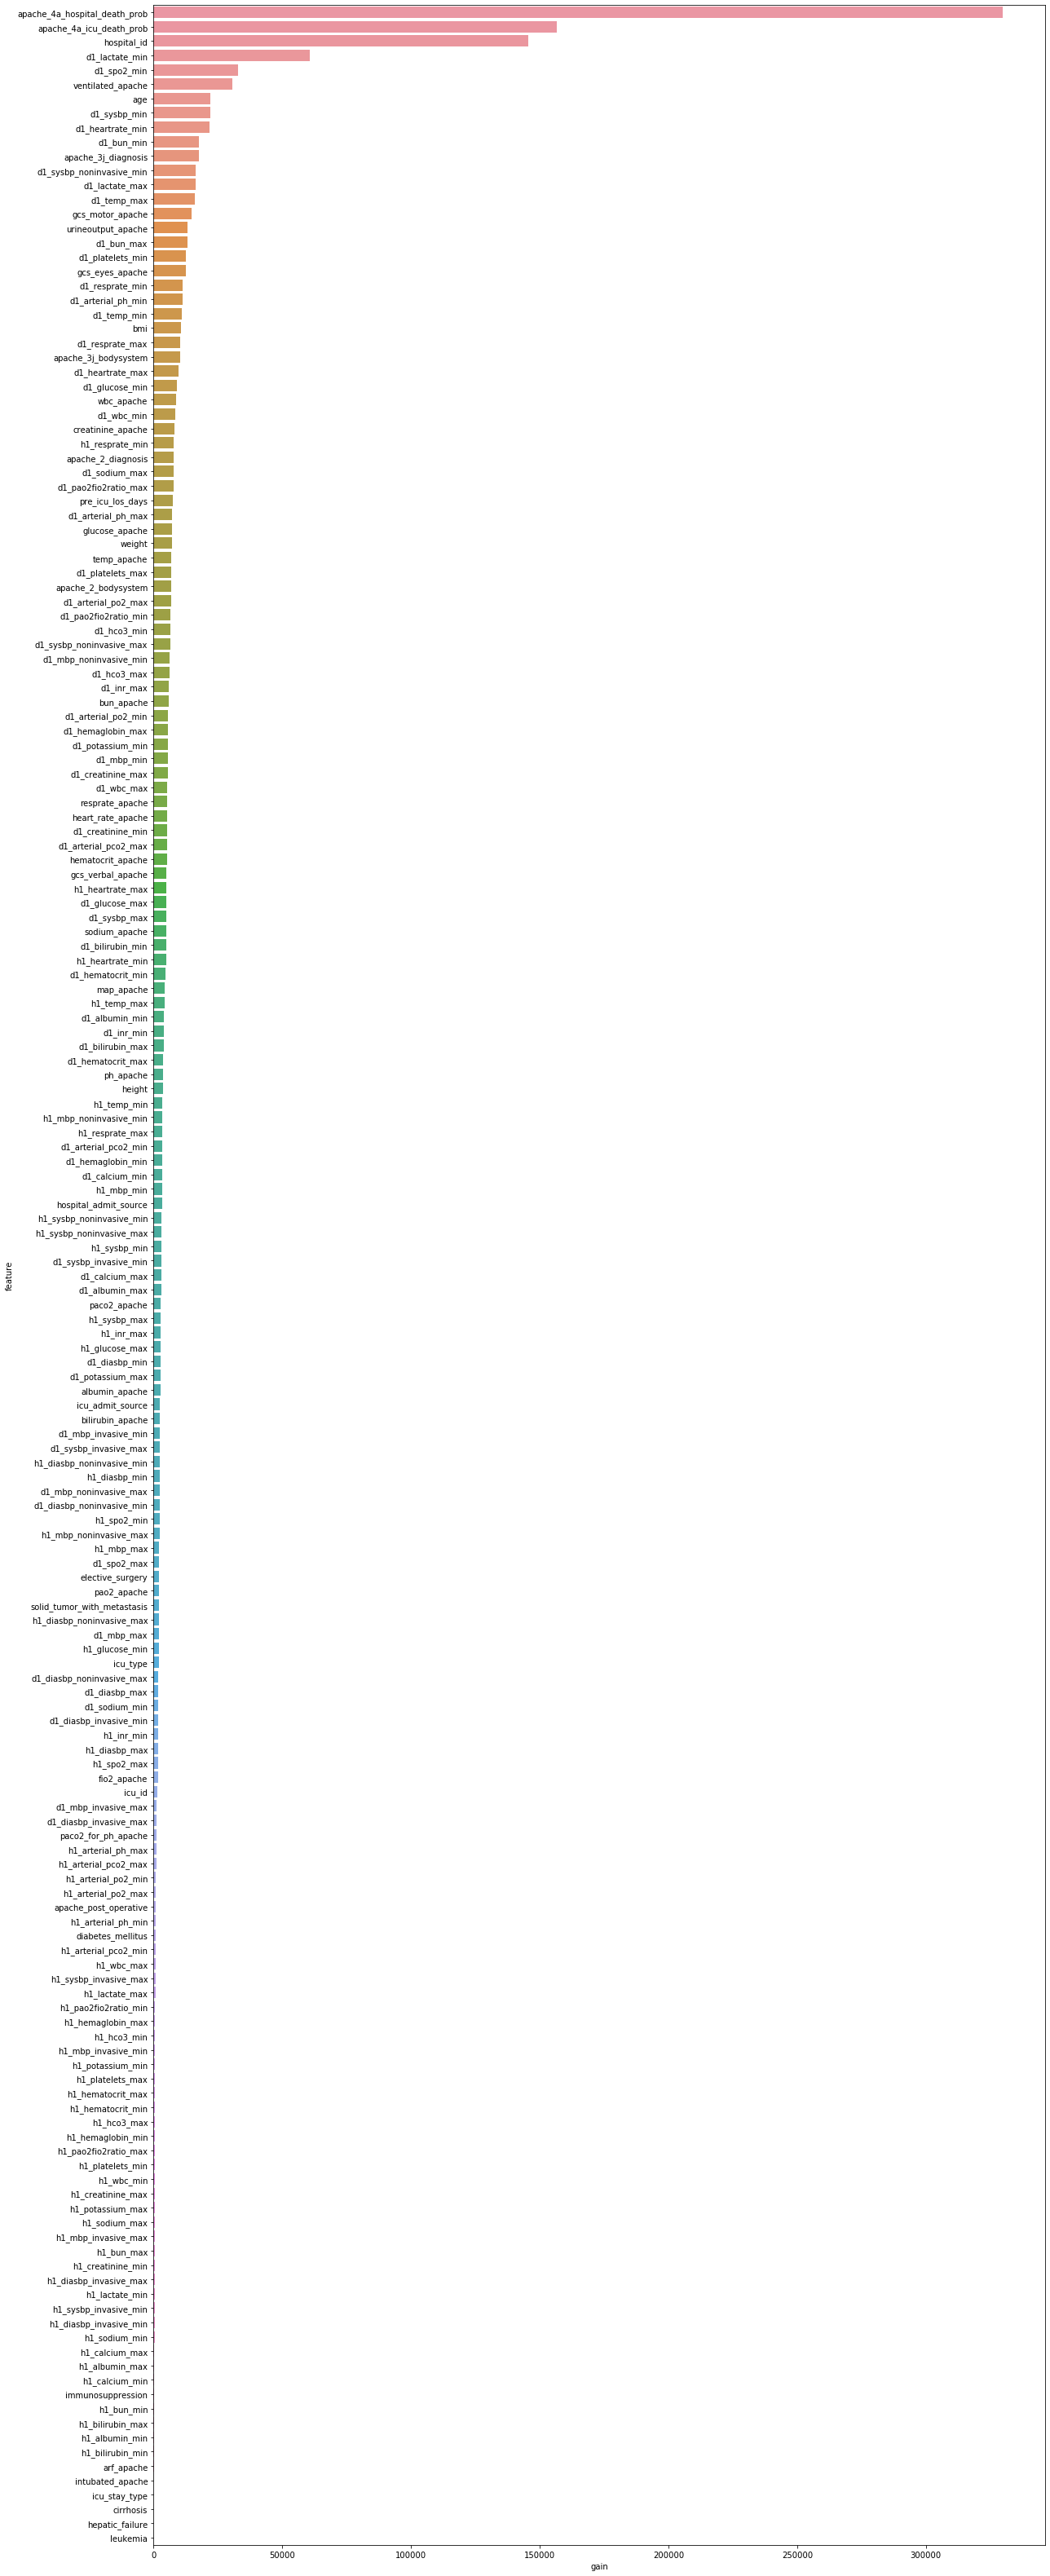

In [34]:
# Plot Feat Importance

imp_df_v2 = pd.DataFrame()
imp_df_v2['feature'] = features
imp_df_v2['gain']  = lgb_model_v2.model.feature_importance(importance_type='gain')
imp_df_v2['split'] = lgb_model_v2.model.feature_importance(importance_type='split')

plot_importances(imp_df_v2)

apache_4a_hospital_death_prob 0 gain : 329680.2181470394


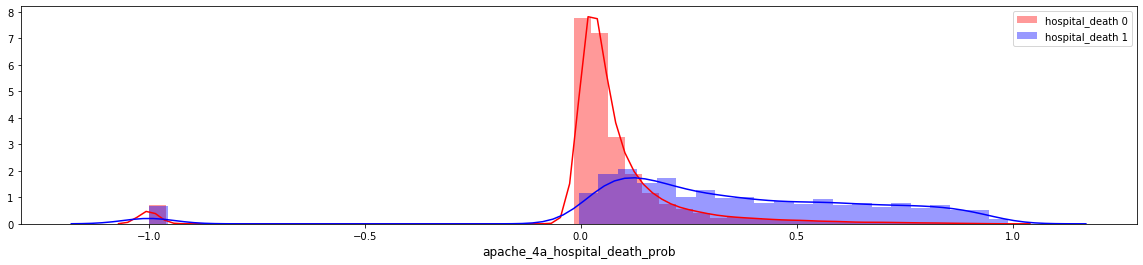

apache_4a_icu_death_prob 1 gain : 156631.5116765499


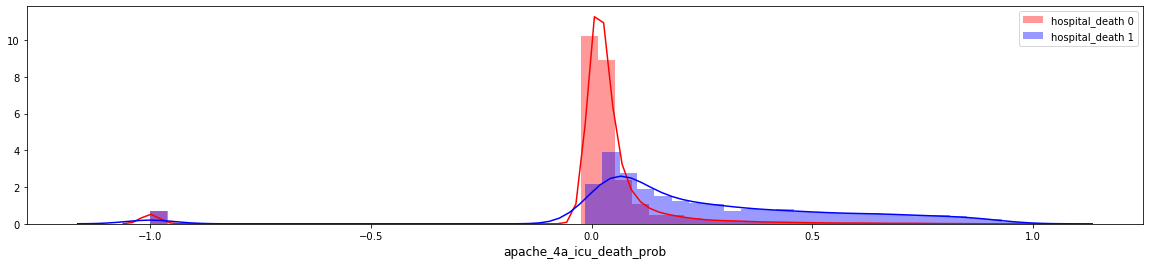

hospital_id 2 gain : 145410.42276763916


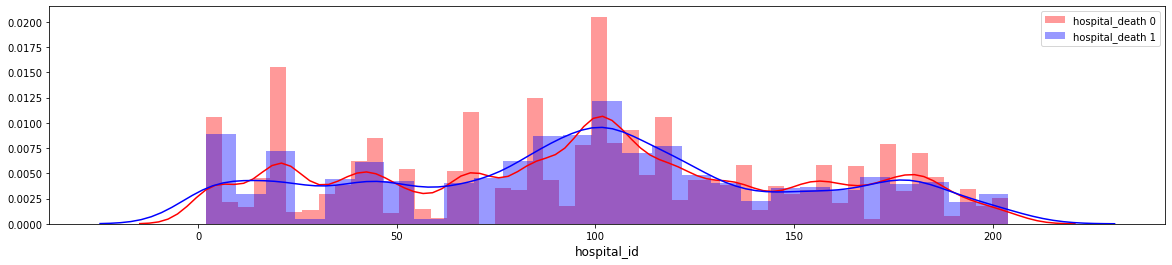

d1_lactate_min 3 gain : 60796.08799648285


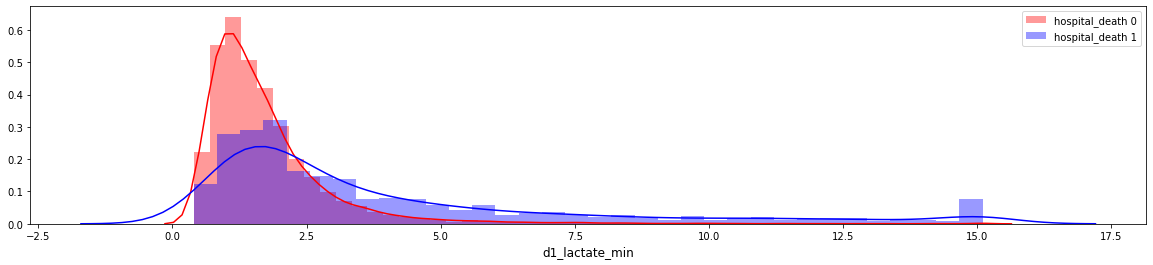

d1_spo2_min 4 gain : 32836.89942884445


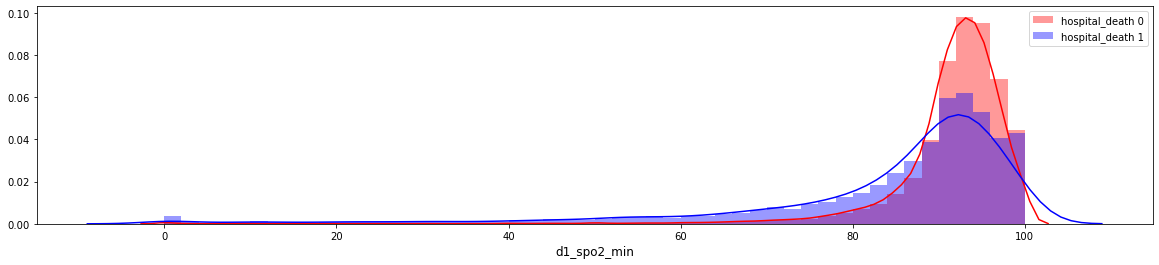

ventilated_apache 5 gain : 30552.519705295563


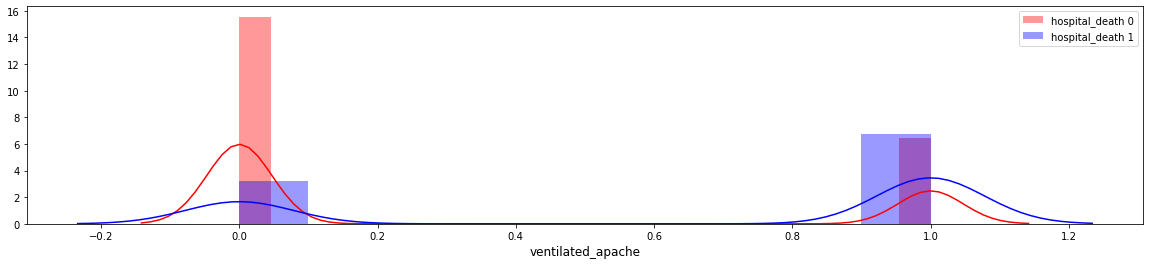

age 6 gain : 22173.600246667862


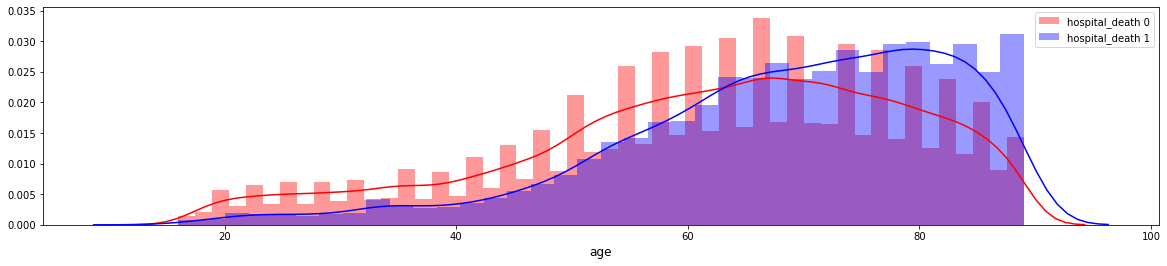

d1_sysbp_min 7 gain : 22129.421936273575


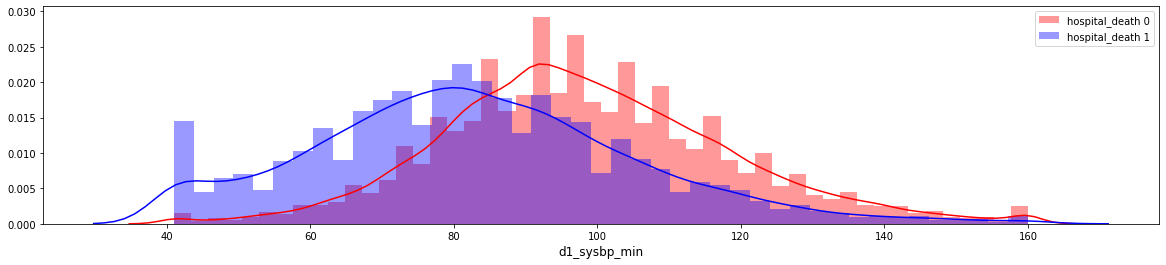

d1_heartrate_min 8 gain : 21593.396679878235


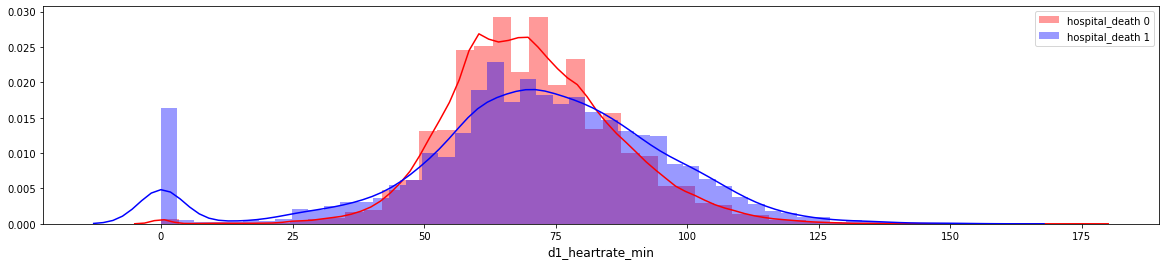

d1_bun_min 9 gain : 17723.877878189087


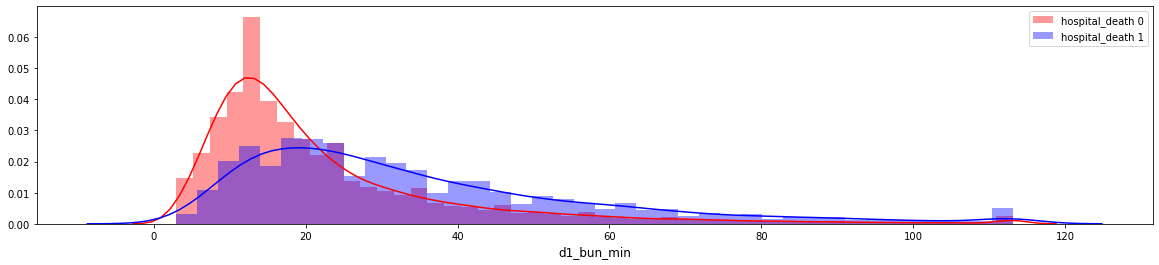

apache_3j_diagnosis 10 gain : 17544.95256614685


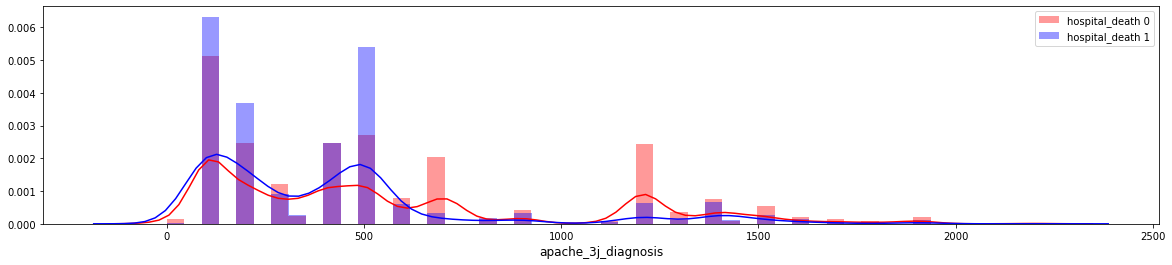

d1_sysbp_noninvasive_min 11 gain : 16455.46886730194


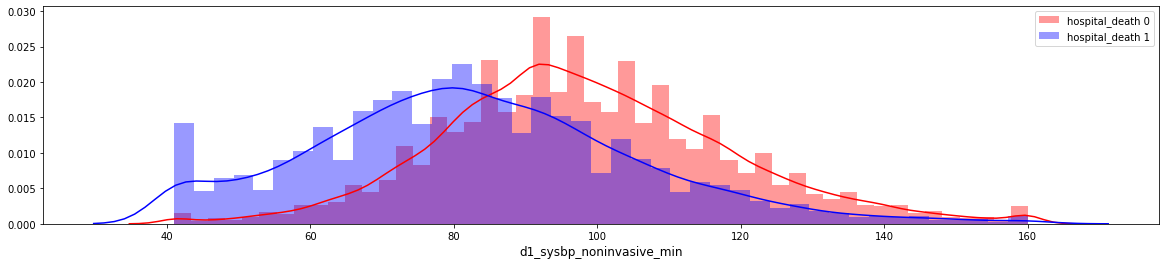

d1_lactate_max 12 gain : 16348.615434885025


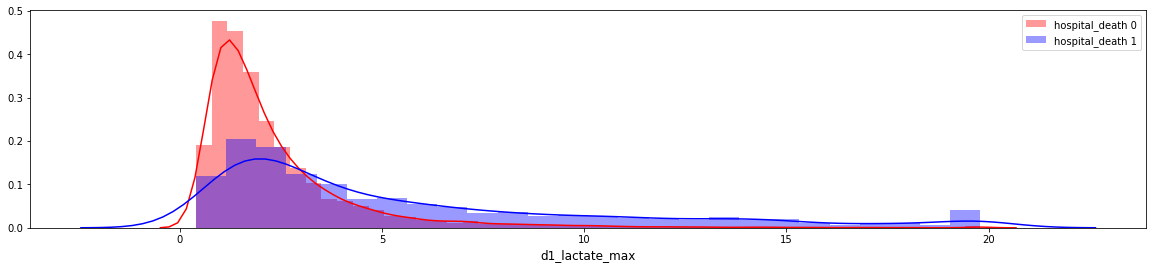

d1_temp_max 13 gain : 15951.985478878021


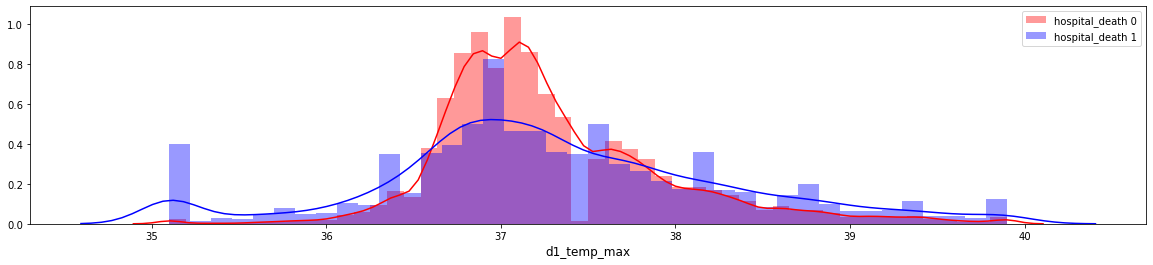

gcs_motor_apache 14 gain : 14751.15071105957


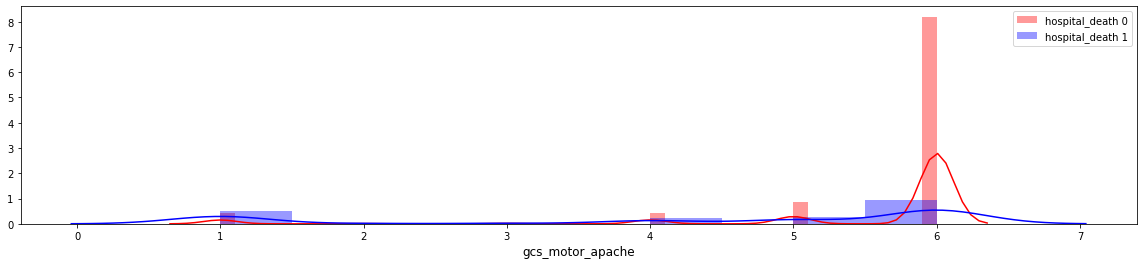

urineoutput_apache 15 gain : 13288.36552143097


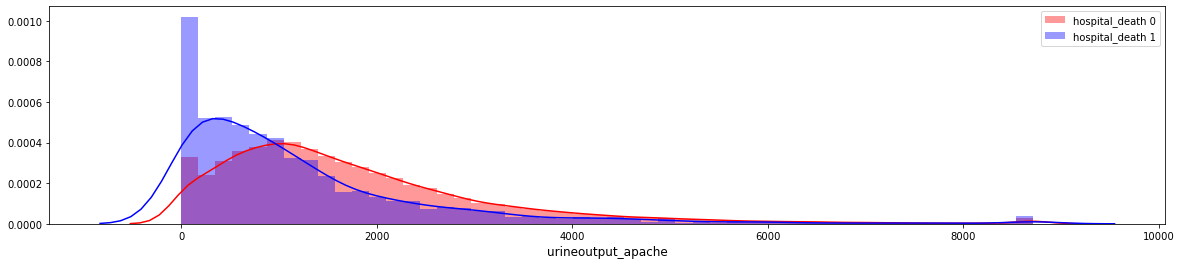

d1_bun_max 16 gain : 13152.739966869354


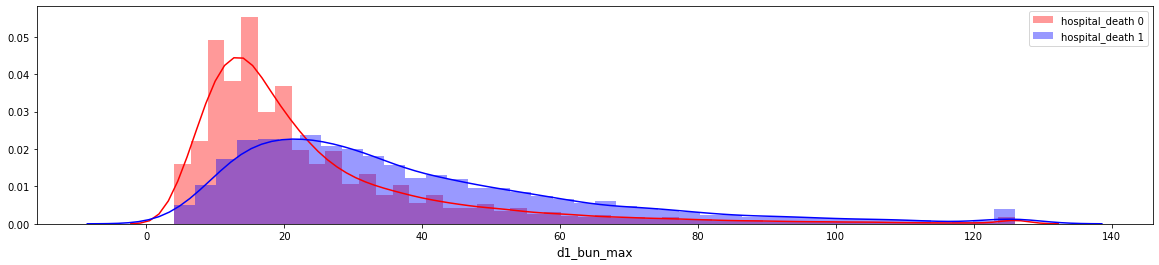

d1_platelets_min 17 gain : 12602.045546770096


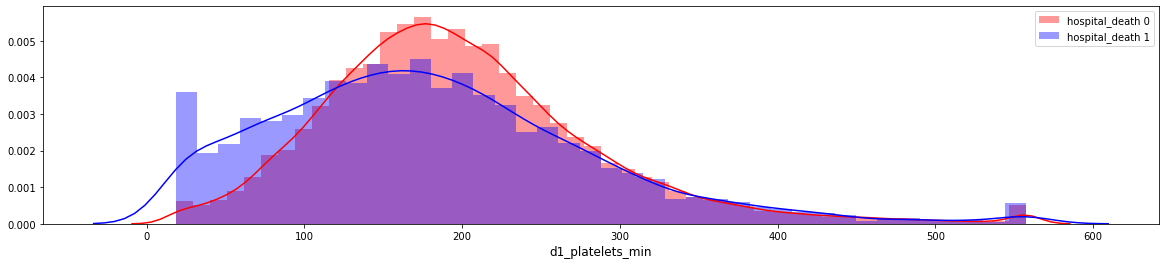

gcs_eyes_apache 18 gain : 12534.613032341003


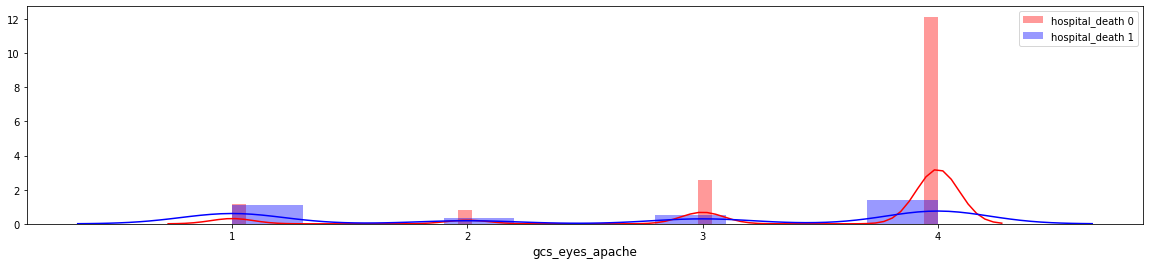

d1_resprate_min 19 gain : 11451.371369123459


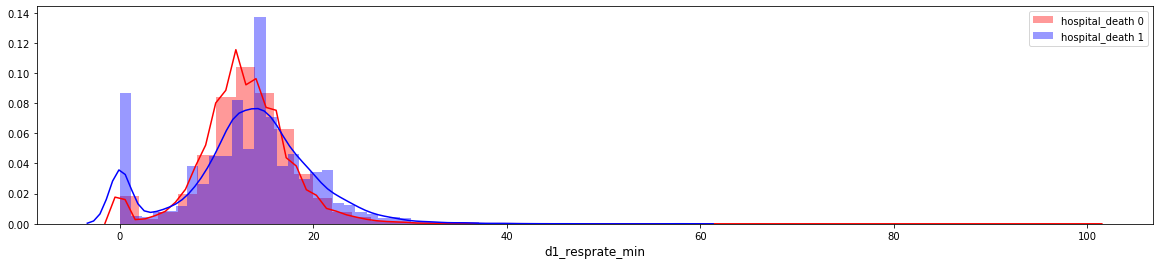

d1_arterial_ph_min 20 gain : 11213.823065042496


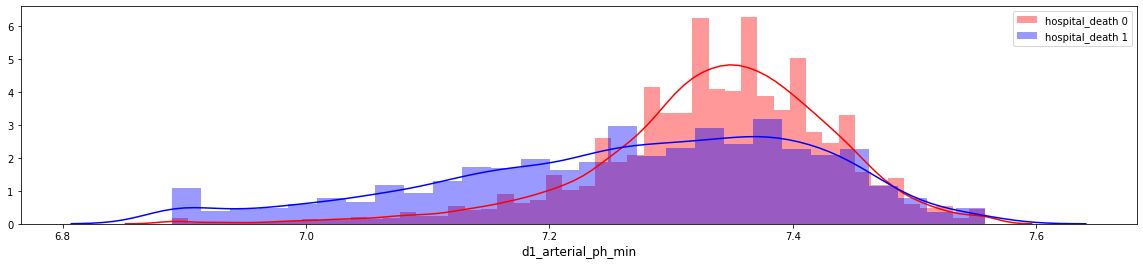

d1_temp_min 21 gain : 11016.257133483887


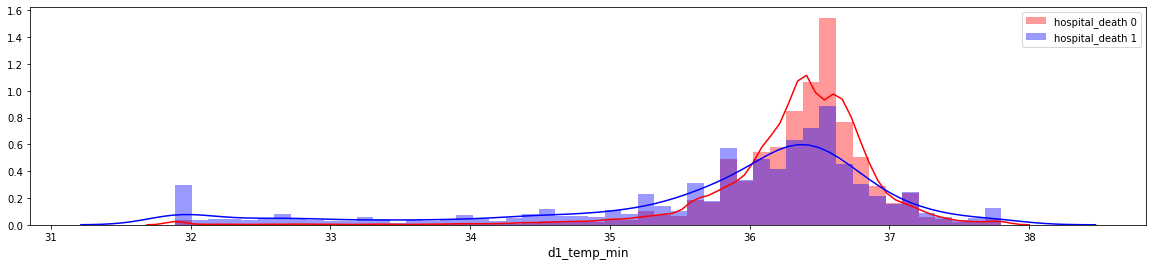

bmi 22 gain : 10569.011886119843


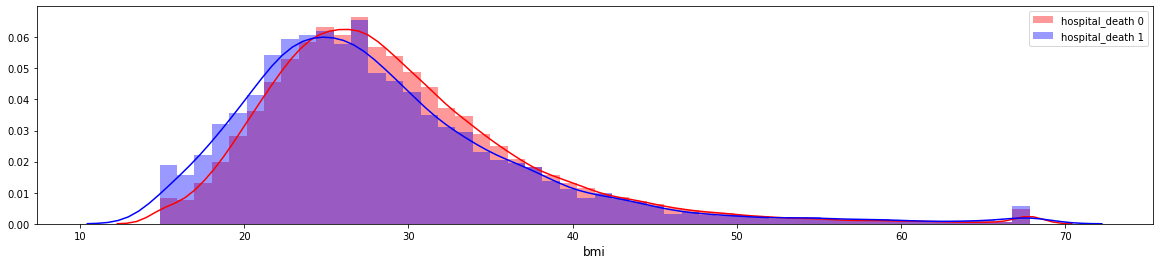

d1_resprate_max 23 gain : 10451.489589452744


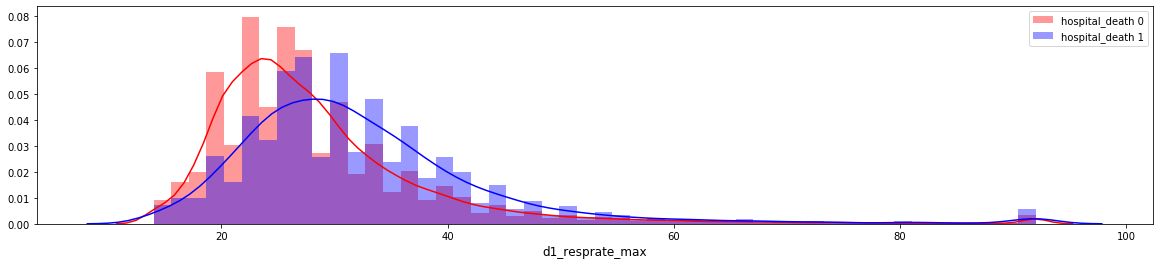

apache_3j_bodysystem 24 gain : 10363.706548213959


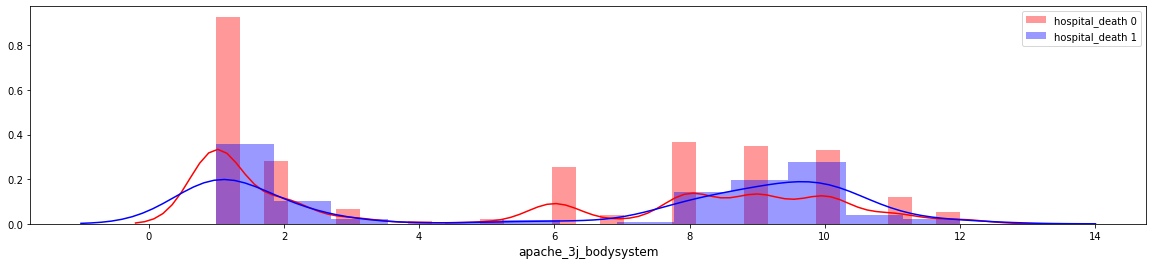

d1_heartrate_max 25 gain : 9830.411767721176


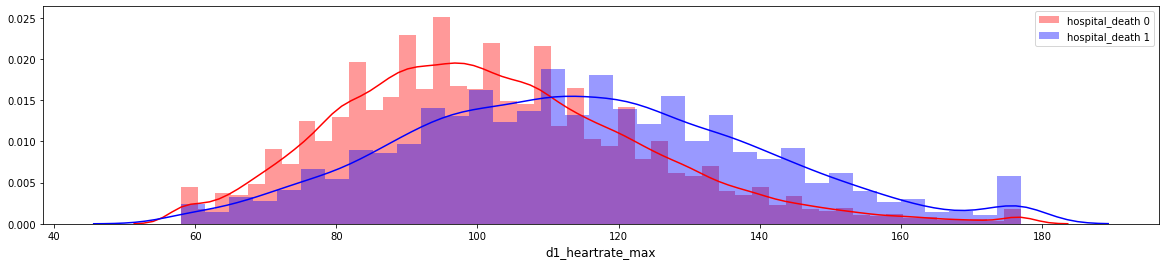

d1_glucose_min 26 gain : 9034.130075931549


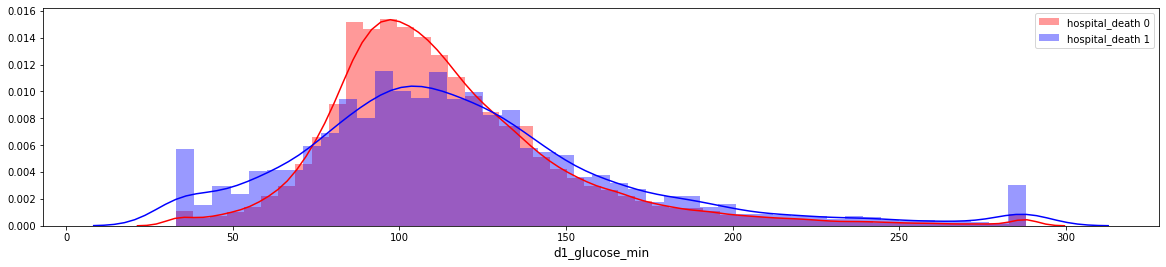

wbc_apache 27 gain : 8726.267885684967


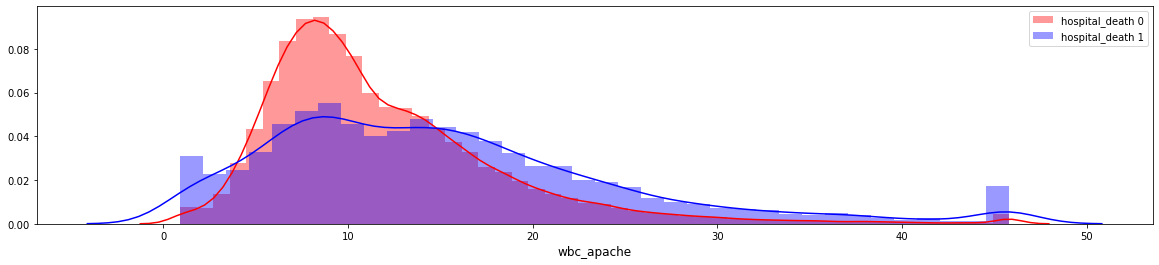

d1_wbc_min 28 gain : 8554.629989147186


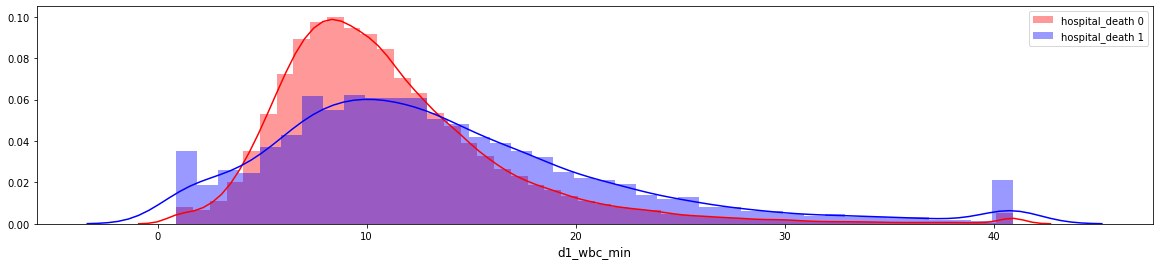

creatinine_apache 29 gain : 8105.224138975143


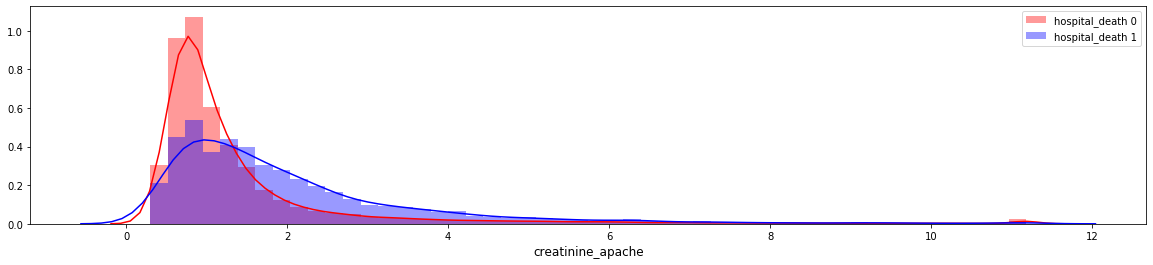

h1_resprate_min 30 gain : 7891.371155738831


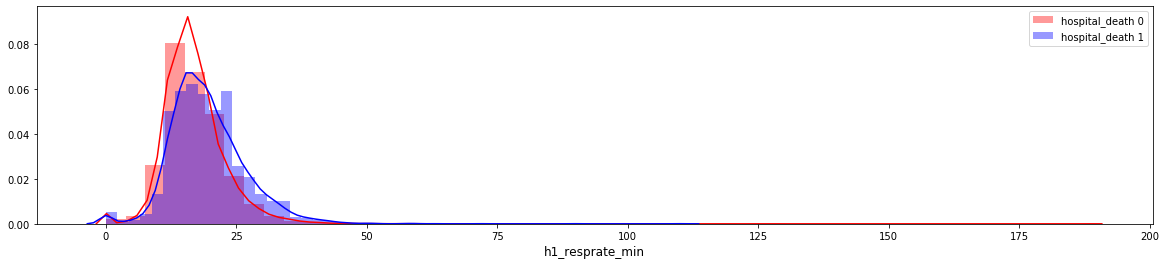

apache_2_diagnosis 31 gain : 7832.032730102539


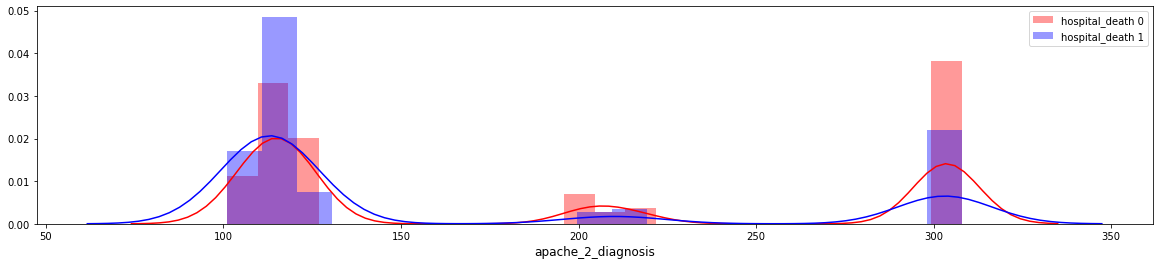

d1_sodium_max 32 gain : 7768.3484926223755


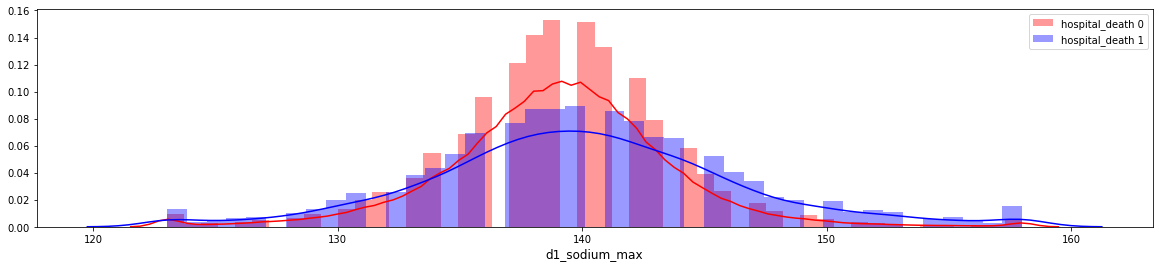

d1_pao2fio2ratio_max 33 gain : 7706.5754590034485


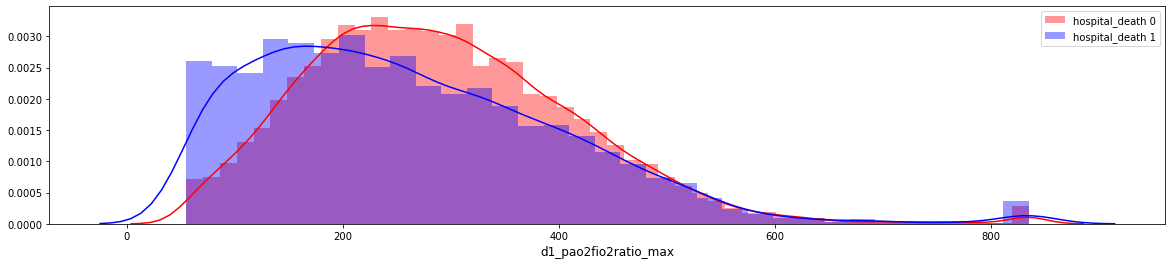

pre_icu_los_days 34 gain : 7615.919073820114


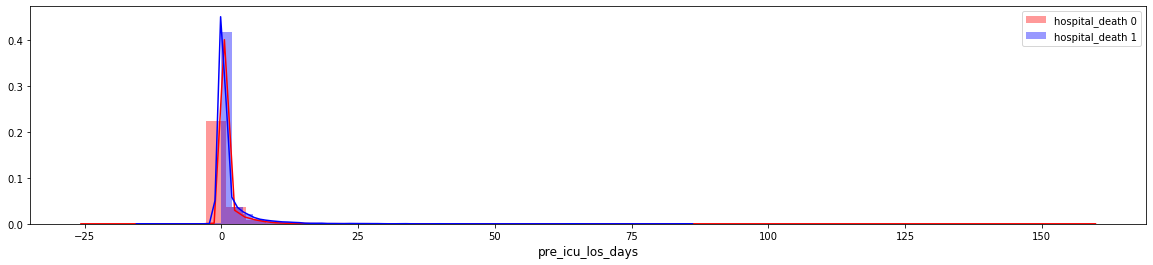

d1_arterial_ph_max 35 gain : 7319.393048524857


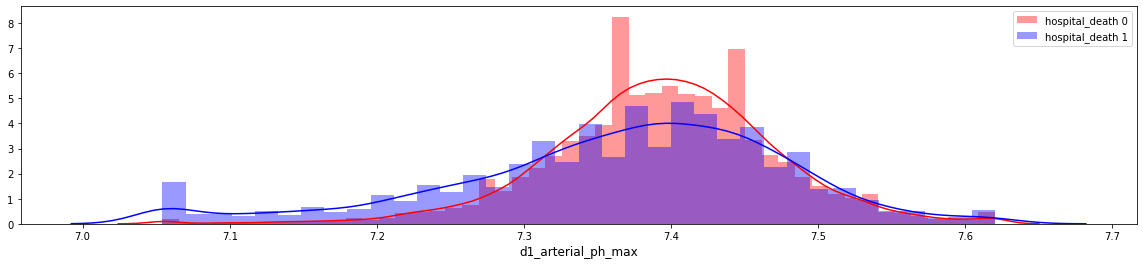

glucose_apache 36 gain : 7211.341676950455


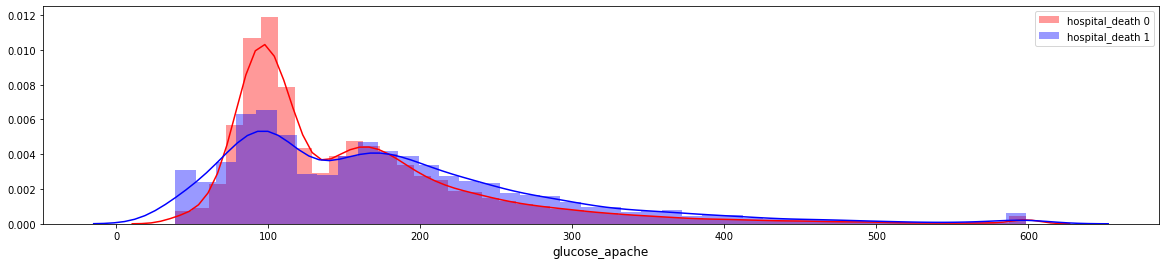

weight 37 gain : 7177.361359834671


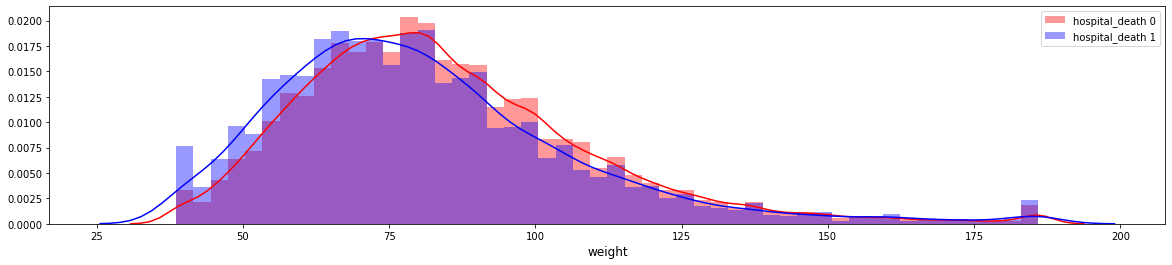

temp_apache 38 gain : 7013.908061504364


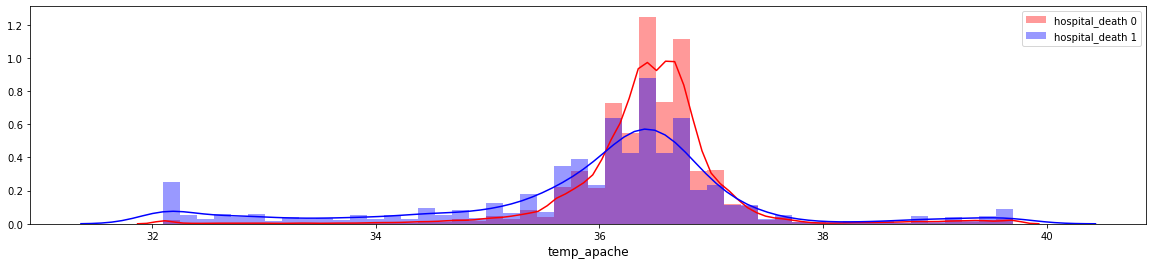

d1_platelets_max 39 gain : 6979.343486785889


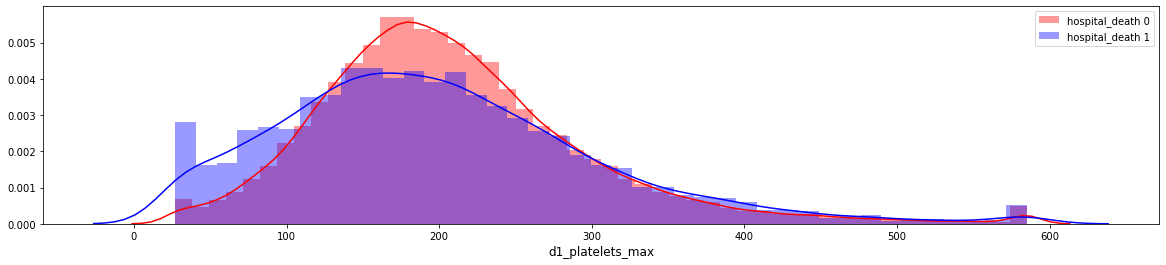

apache_2_bodysystem 40 gain : 6878.724554777145


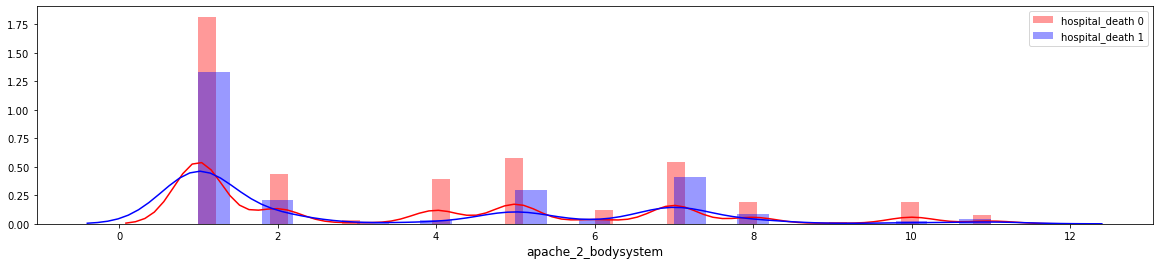

d1_arterial_po2_max 41 gain : 6779.606928348541


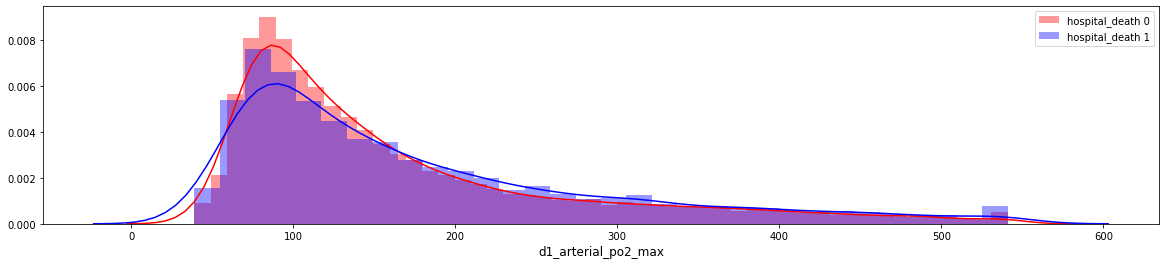

d1_pao2fio2ratio_min 42 gain : 6671.06258058548


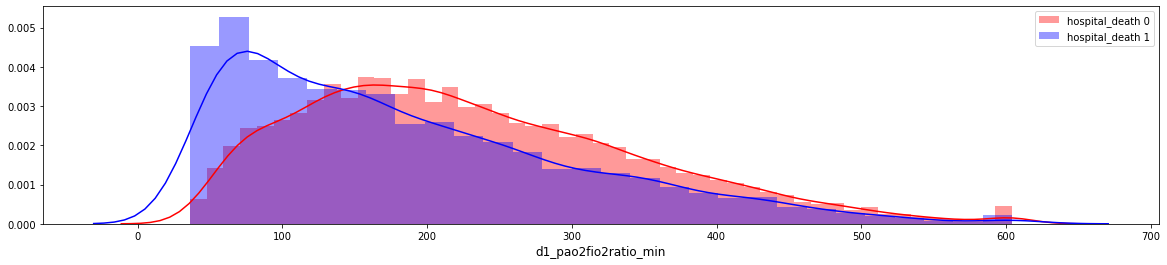

d1_hco3_min 43 gain : 6501.838881731033


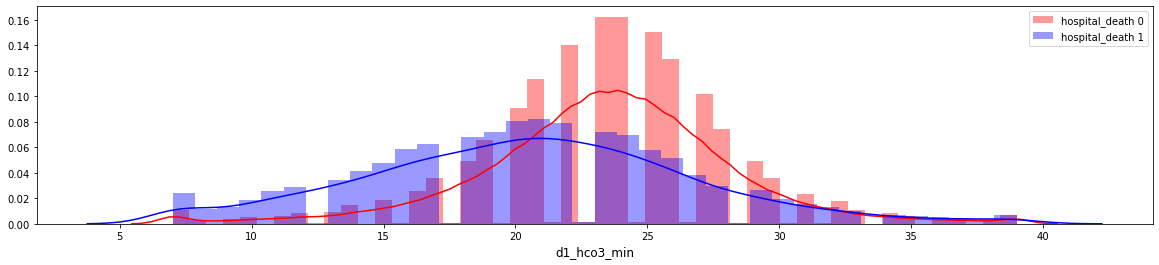

d1_sysbp_noninvasive_max 44 gain : 6441.646271944046


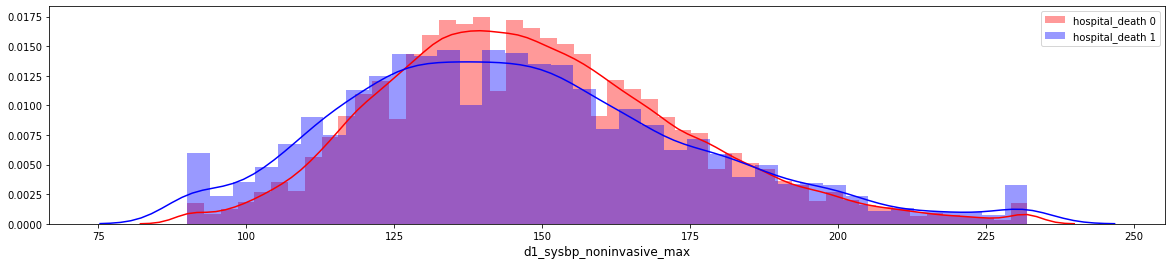

d1_mbp_noninvasive_min 45 gain : 6383.477047920227


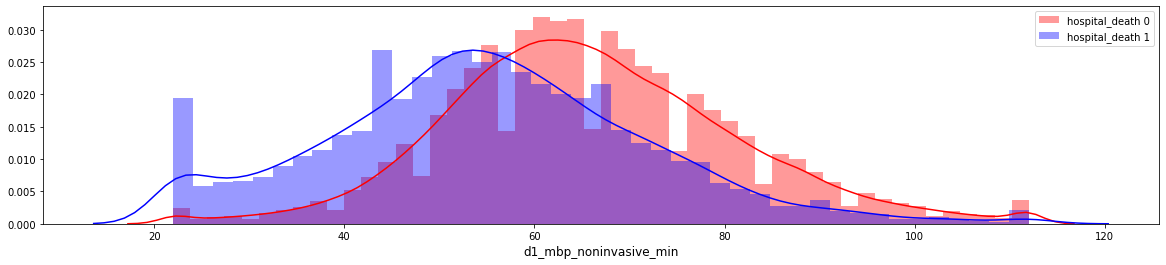

d1_hco3_max 46 gain : 6359.334758520126


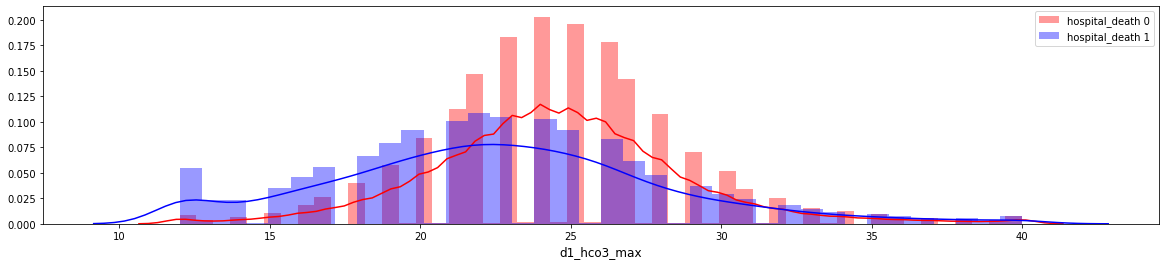

d1_inr_max 47 gain : 5976.186361789703


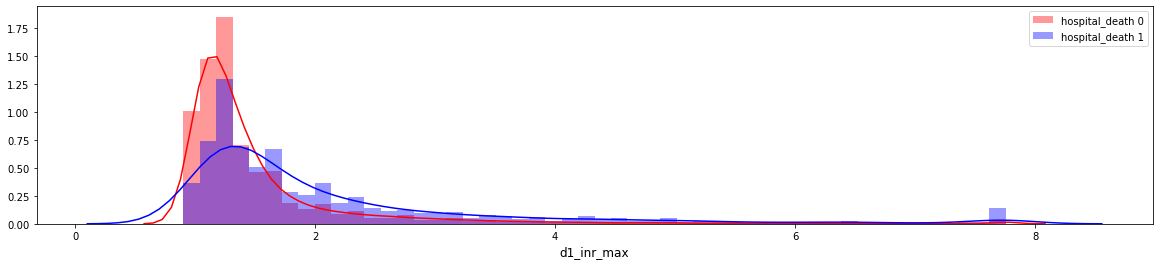

bun_apache 48 gain : 5789.338826417923


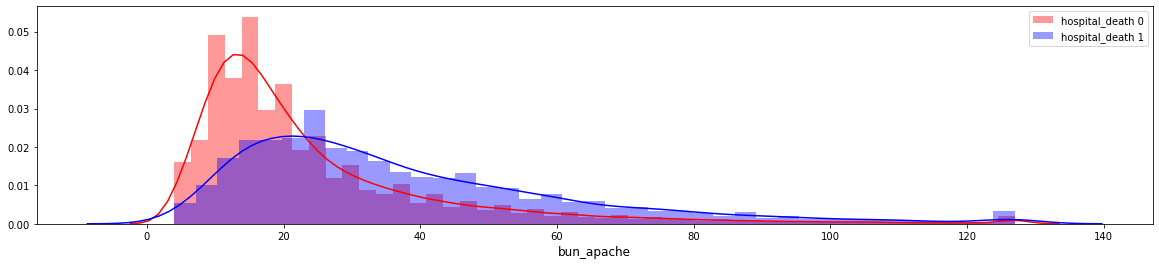

d1_arterial_po2_min 49 gain : 5672.42506146431


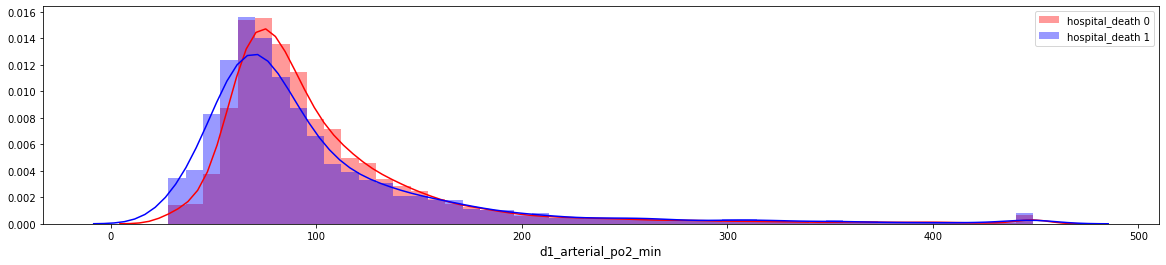

In [39]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
i=0
for index, row in imp_df_v2.sort_values(by=['gain'],ascending=False).iterrows():  
    column=row['feature']
    if i< 50:
            print(column,i,"gain :",row['gain'])
            df1      = train.loc[train['hospital_death']==0]
            df2      = train.loc[train['hospital_death']==1]

            fig = plt.figure(figsize=(20,4))
            sns.distplot(df1[column].dropna(),  color='red', label='hospital_death 0', kde=True); 
            sns.distplot(df2[column].dropna(),  color='blue', label='hospital_death 1', kde=True); 
            fig=plt.legend(loc='best')
            plt.xlabel(column, fontsize=12);
            plt.show()
            i=i+1


## Submissing File

In [37]:
test["hospital_death"] = lgb_model_v2.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission4-lgb-v3.csv",index=False)

test[["encounter_id","hospital_death"]].head()

encounter_id       hospital_death
0  2                            0.01
1  5                            0.02
2  7                            0.01
3  8                            0.12
4  10                           0.66